# Initial Condition Sensitivity analysis on a Batch of data 

In [2]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import os
from sys import platform

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import h5py
import pandas as pd
import random

from joblib import Parallel, delayed
import multiprocessing

import pyfilaments.analysisutils as analysis
from pyfilaments.activeFilaments import activeFilament

import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    # root_path = '/home/deepak/Dropbox/LacryModeling/ModellingResults'
    root_path = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults'

elif platform == 'darwin':
    print("OSX system")
    root_path = '/Users/deepak/Dropbox/LacryModeling/ModellingResults'
    
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure3'

if(not os.path.exists(publication_figures)):
    os.makedirs(publication_figures)

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [17]:
# Global parameters
DELTA_IC = 1e-2 # Average distance between nearby ICs.

N_transient = 400 # No:of activity cycles for transients to decay. 

N_IC_time = 10 # IC based on different activity cycles/time
N_IC_phase = 1 # Different IC within each activity phase

N_IC_nearby = 10

N_ACTIVITY_CYCLES = 20 # No:of activity cycles to simulate for IC sensitivity analysis

## Function definitions

In [3]:
def choose_ic_time_phase(fil):
    """Takes a filament simulation and returns randomly chosen time points at a randomly chosen phase
        along the activity cycle.
    """
    N_cycles = int(fil.Time[-1]/fil.activity_timescale)

    # Choose n random activity cycles (time)
    n_cycles = random.sample(range(N_transient, N_cycles), N_IC_time)

    # Within each activity cycle choose points evenly distributed in phase
    n_phase = random.sample(list(np.linspace(0, 2*np.pi, 100)), N_IC_phase)

    # Compute the minimum resolved phase difference in the simulations
    delta_phase = 2*np.pi*np.mean(fil.Time[1:] - fil.Time[:-1])/fil.activity_timescale # Smallest change in phase

    time_points = np.array(range(0, len(fil.Time)))
    # Find the index corresponding to each unique IC

    # Create empty array to store indices for each unique IC
    ic_mesh = np.empty((N_IC_time, N_IC_phase), dtype = int)

    # Phase array for the whole simulation
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale

    for ii, phase in enumerate(n_phase):

        abs_val_array = np.abs(fil.derived_data['Phase'] - phase)
        constant_phase_mask = abs_val_array <= 0.5*delta_phase
        time_indices = time_points[constant_phase_mask]
        ic_mesh[:, ii] = time_indices[n_cycles]
        
    return ic_mesh


def generate_close_ic(fil = None, ic_mesh = None, rn_seed = 0):
    """ Start with a filament shape at the randomly chosen time-points and generate closely spaced ICs 
        by adding random perturbation with a small amplitide \delta_IC
        
        Store these ICs as .hdf5 files in the IC_analysis folder within the simulation data folder.
        
        Returns: Nothing
    """
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)
    # Use a fixed seed to generate repeatable random numbers
    np.random.seed(rn_seed)

    filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)

    delta_theta_array = DELTA_IC*np.random.randn(N_IC_nearby)
    
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale

    
    
    for ii in range(N_IC_time):

        for jj in range(N_IC_phase):

            time_index = ic_mesh[ii, jj]

            phase = phase_array[time_index]

            ic_folder = os.path.join(fil.ic_analysis_folder, 'IC_{}'.format(time_index))

            if(not os.path.exists(ic_folder)):
               os.makedirs(ic_folder)

            filament_shape = fil.R[time_index,:]
#             plt.figure(figsize=(2,2))
#             fil.plotFilament(r = filament_shape)
#             plt.title(time_index)
#             plt.axis('equal')

            for kk in range(N_IC_nearby):
                #-------------------------------
                # Method 1 : Random transverse perturbation
                #-------------------------------
                 # Add noise along X direction
                filament_init_shape[1:fil.Np] = \
                filament_shape[1:fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                # Add noise along Y direction
                filament_init_shape[fil.Np+1:2*fil.Np] = \
                filament_shape[fil.Np+1:2*fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                #-------------------------------
                # Method 2 : Add a solid body rotation.
                #-------------------------------
    #             delta_theta = delta_theta_array[kk]

    #             x_pos = filament_init_shape[0:fil.Np]
    #             y_pos = filament_init_shape[fil.Np:2*fil.Np]

    #             delta_x = -delta_theta*y_pos
    #             delta_y = delta_theta*x_pos

    #             filament_init_shape[0:fil.Np] = filament_shape[0:fil.Np] + delta_x
    #             filament_init_shape[fil.Np:2*fil.Np] = filament_shape[fil.Np:2*fil.Np] + delta_y
    
                save_file = 'filament_ic_{0:03d}.hdf5'.format(kk)
                # Save the resulting filament shapes to disk
                with h5py.File(os.path.join(ic_folder, save_file), "w") as f:

                    dset = f.create_group("simulation data")
                    dset.create_dataset("Initial Position", data = filament_init_shape)
                    dset.attrs['Time index'] = time_index
                    # Also save the phase value of the simulation
                    dset.attrs['Phase'] = phase
                    

def create_batchsim_table(folders = None, fil = None):
    
    """ Create a table/dict of IC for filament shape along with phase info that can be passed to run a Parallel job
        
        Input: Folder containing IC files. This folder should contain IC that are closely spaced together. 
        
        Returns: ic_list (dict containing: path, filename, filament shape and phase of each IC)
    
    """
    # Create a dictionary to store all IC we want to simulate
    ic_table = {}
    ic_counter = 0
    
    root_folder = fil.ic_analysis_folder
    
    
    
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)

    for folder in folders:

        ic_files = os.listdir(os.path.join(root_folder, folder))
     
        for file in ic_files:
            
            if(file.endswith('.hdf5')):
                with h5py.File(os.path.join(root_folder, folder, file), "r") as f:
                    if('simulation data' in f.keys()): # Load the simulation data
                        dset = f['simulation data']
                        r = np.array(dset["Initial Position"][:])
                        time_point = int(dset.attrs["Time index"])
                        phase = dset.attrs['Phase']


                ic_table[ic_counter] = {'path':os.path.join(root_folder, folder), 'ic':file[:-5], 'filament shape':r, 'phase':phase}


                ic_counter+=1
            
    return ic_table

def run_ic_simulation_batch(fil = None, ic_table = None):
    """ Runs a batch/parallel simulation on a set of N_IC closely spaced ICs specified using ic_table 
        for a given filament
        Inputs: filament object containing the filament corresponding to the current parameter value
                ic_table: List of ICs to simulate
                
        Returns: Nothing. Saves results of the IC simulations to disk.
    """
    #-----------------------------------------------------------------------------------------------------
    def run_ic_simulation(ic, path, filament_shape, phase):
#     """Run a filament simulation using specified parameters
#     """
        # Simulate each IC
        new_fil = activeFilament(dim = dim, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

        new_fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = True, overwrite = False, path = path, sim_type = 'point', 
        init_condition = {'filament':filament_shape}, 
        activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':0.5, 'start phase':phase},
                     note = ic, create_subdirs=False, ic_sim = True)
    #-----------------------------------------------------------------------------------------------------
    # No:of activity cycles we want to simulate
    n_activity_cycles = N_ACTIVITY_CYCLES
    # Total simulation time
    Tf = fil.activity_timescale*n_activity_cycles

    # Total simulation time
    # No:of time points saved
    time_step_save = 10
    Npts = int(Tf/time_step_save)

    bc = {0:'clamped', -1:'free'}

    dim = fil.dim
    Np = fil.Np
    radius = fil.radius
    b0 = fil.b0
    k = fil.k
    S0 = fil.S0
    D0 = fil.D0
    activity_timescale = fil.activity_timescale
    
    # Run the Parallel/Batch simulations
    num_cores = multiprocessing.cpu_count()
    print(num_cores)
    num_cores = 12
    results = Parallel(n_jobs = num_cores,  verbose=10)(delayed(run_ic_simulation)(ic_table[ic_index]['ic'], ic_table[ic_index]['path'], ic_table[ic_index]['filament shape'], ic_table[ic_index]['phase']) for ic_index in tqdm(ic_table.keys()))


## Run the Batch Simulations for Initial Condition Sensitivity

### Batch simulation procedure

For each simulation parameter 

### Step 1: Generate closely spaced ICs
1. Find one instance of a completed simulation. If no completed simulations then skip this parameter.
2. Load this simulation file to memory.
3. Choose random points separated in time.
4. Generate and save closely separated filament ICs by adding small perturbations of amplitude \delta_IC.

### Step 2: Run simulations starting from the closely spaced ICs for each parameter values.
1. Run simulations starting from each of these ICs for all the random time points.
2. Save the Results to file







In [3]:
# batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'

# Full data
batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'
data_folders = os.listdir(batch_data_folder)

print(len(data_folders))

40


### Step 1: Generate closely spaced ICs

In [5]:
# Step 1: Generate closely spaced ICs

plt.close('all')
for folder in tqdm(data_folders):
    
    cwd = os.path.join(batch_data_folder, folder)
    os.chdir(cwd)
    found_completed_sim = False
    
    files = [file for file in os.listdir(cwd) if file.endswith('.hdf5')]
    plt.close('all')
    while found_completed_sim == False:
        
        for file in files:
            
            full_path = os.path.join(batch_data_folder, folder, file)
            
            fil = analysis.analysisTools(file = full_path)
            
            ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
    
            fil.ic_analysis_folder = ic_analysis_folder
            
            if(fil.Time[-1]==500*fil.activity_timescale):
                # If simulation has at least 500 activity cycles then use it to generate ICs
                print(50*'*')
                print('Completed simulation found!')
                print('Generating closely spaced initial conditions...')
                print(50*'*')
                # Generate and save the ICs
                
                ic_mesh = choose_ic_time_phase(fil)
                generate_close_ic(fil = fil, ic_mesh = ic_mesh)
                
                # Also store the exact completed simulation file we are using to generate ICs
                df_sim_file = pd.DataFrame({'sim file':[file]})
                
                df_sim_file.to_csv(os.path.join(fil.ic_analysis_folder,'sim_file.csv'))
                found_completed_sim = True
                # ----------------------------------------------- We can break the workflow here
                
            if found_completed_sim==True:
                break
                
        if(found_completed_sim==False):
            print('No completed sims found for this condition...')
            break
                
#                 create_batchsim_table(folders = ic_folders, fil = fil) 

  5%|▌         | 2/37 [00:00<00:02, 13.46it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 16%|█▌        | 6/37 [00:00<00:02, 14.96it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
No completed sims found for this condition...
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 22%|██▏       | 8/37 [00:00<00:02, 14.06it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 32%|███▏      | 12/37 [00:00<00:01, 13.01it/s]

No completed sims found for this condition...
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 38%|███▊      | 14/37 [00:01<00:01, 12.92it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 43%|████▎     | 16/37 [00:01<00:01, 12.60it/s]

No completed sims found for this condition...
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 54%|█████▍    | 20/37 [00:01<00:01, 11.47it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 59%|█████▉    | 22/37 [00:01<00:01, 11.87it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 70%|███████   | 26/37 [00:02<00:00, 12.86it/s]

No completed sims found for this condition...
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 76%|███████▌  | 28/37 [00:02<00:00, 11.90it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 86%|████████▋ | 32/37 [00:02<00:00, 12.36it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


100%|██████████| 37/37 [00:02<00:00, 12.88it/s]

No completed sims found for this condition...
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
No completed sims found for this condition...


### Step 2: Run IC simulations starting from the generated ICs

In [6]:
# Step 2: Run IC simulations starting from the generated ICs

for folder in tqdm(data_folders):
    
    cwd = os.path.join(batch_data_folder, folder)
    os.chdir(cwd)
    
    if(os.path.exists(os.path.join(cwd, 'IC_analysis'))):
        df_sim_file = pd.read_csv(os.path.join(cwd, 'IC_analysis', 'sim_file.csv'))
        
        full_path = os.path.join(cwd, df_sim_file['sim file'][0])
            
        fil = analysis.analysisTools(file = full_path)
        
        ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
        
        fil.ic_analysis_folder = ic_analysis_folder
        
        ic_folders = [folder for folder in os.listdir(fil.ic_analysis_folder) if not folder.endswith('.csv')]
        
        ic_table = create_batchsim_table(folders=ic_folders, fil = fil)
        
        run_ic_simulation_batch(ic_table= ic_table, fil = fil)

  0%|          | 0/100 [00:00<?, ?it/s]

16


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.

 12%|█▏        | 12/100 [00:18<00:01, 53.30it/s][Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:06<04:06,  3.24s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.8min

 36%|███▌      | 36/100 [02:11<04:30,  4.23s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.2min

 48%|████▊     | 48/100 [03:57<05:14,  6.05s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.5min

 60%|██████    | 60/100 [05:30<04:27,  6.68s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.8min

 72%|███████▏  | 72/100 [06:58<03:12,  6.89s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.7min

100%|██████████| 100/100 [10:10<00:00,  6.10s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.9min remaining:  1.6min

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   58.2s

 24%|██▍       | 24/100 [00:58<03:04,  2.42s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.8min

 36%|███▌      | 36/100 [01:57<03:43,  3.49s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:32<04:26,  5.12s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [05:02<03:58,  5.96s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.0min

 72%|███████▏  | 72/100 [06:26<02:56,  6.29s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.6min

100%|██████████| 100/100 [08:53<00:00,  5.33s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.7min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.8min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:03<03:21,  2.66s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  2.0min

 36%|███▌      | 36/100 [02:14<04:16,  4.00s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.0min

 48%|████▊     | 48/100 [03:56<04:56,  5.69s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.8min

 60%|██████    | 60/100 [05:46<04:35,  6.88s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.9min

 72%|███████▏  | 72/100 [06:57<03:04,  6.57s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.4min

100%|██████████| 100/100 [10:02<00:00,  6.02s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 12.1min remaining:  1.6min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.1min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:03<03:22,  2.66s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [02:08<04:02,  3.79s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.8min

 48%|████▊     | 48/100 [03:29<04:14,  4.90s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:50<03:41,  5.53s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.4min

 72%|███████▏  | 72/100 [06:28<03:00,  6.43s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [09:02<00:00,  5.42s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.0min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.9min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.9s

 24%|██▍       | 24/100 [00:56<03:00,  2.37s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:54<03:35,  3.37s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:20<04:09,  4.80s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:47<03:46,  5.65s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.0min

 72%|███████▏  | 72/100 [06:07<02:47,  5.99s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.6min

100%|██████████| 100/100 [08:47<00:00,  5.27s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.6min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.3s

 24%|██▍       | 24/100 [00:56<02:58,  2.35s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:53<03:35,  3.36s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.5min

 48%|████▊     | 48/100 [03:24<04:15,  4.92s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.9min

 60%|██████    | 60/100 [04:53<03:51,  5.80s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  5.9min

 72%|███████▏  | 72/100 [05:55<02:36,  5.59s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:55<00:00,  5.36s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.5min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:04<03:24,  2.69s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  2.0min

 36%|███▌      | 36/100 [02:12<04:11,  3.92s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.8min

 48%|████▊     | 48/100 [03:57<04:57,  5.73s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.3min

 60%|██████    | 60/100 [05:20<04:05,  6.14s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  7.2min

 72%|███████▏  | 72/100 [07:12<03:21,  7.20s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.7min

100%|██████████| 100/100 [10:10<00:00,  6.10s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.9min remaining:  1.6min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.2min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   57.6s

 24%|██▍       | 24/100 [00:57<03:02,  2.40s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:55<03:38,  3.41s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:34<04:30,  5.21s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:50<03:44,  5.60s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.1min

 72%|███████▏  | 72/100 [06:06<02:43,  5.84s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.6min

100%|██████████| 100/100 [08:47<00:00,  5.27s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.4min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.7s

 24%|██▍       | 24/100 [00:56<02:59,  2.36s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:53<03:35,  3.37s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.9min

 48%|████▊     | 48/100 [03:26<04:18,  4.97s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.9min

 60%|██████    | 60/100 [04:52<03:49,  5.74s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.1min

 72%|███████▏  | 72/100 [06:10<02:47,  5.99s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:51<00:00,  5.31s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.5min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   55.1s

 24%|██▍       | 24/100 [00:55<02:54,  2.30s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:51<03:30,  3.29s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:20<04:11,  4.84s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.7min

 60%|██████    | 60/100 [04:43<03:42,  5.55s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  5.9min

 72%|███████▏  | 72/100 [06:00<02:43,  5.83s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:32<00:00,  5.12s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.2min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.3min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.0min

 24%|██▍       | 24/100 [01:01<03:16,  2.58s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [01:59<03:45,  3.52s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.0min

 48%|████▊     | 48/100 [03:20<04:04,  4.70s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [05:01<04:00,  6.00s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.1min

 72%|███████▏  | 72/100 [06:13<02:48,  6.01s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [08:54<00:00,  5.35s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.7min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.2min

 24%|██▍       | 24/100 [01:11<03:47,  2.99s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [02:27<04:40,  4.39s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.9min

 48%|████▊     | 48/100 [03:34<04:10,  4.81s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.2min

 60%|██████    | 60/100 [05:11<03:58,  5.97s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.6min

 72%|███████▏  | 72/100 [06:43<03:02,  6.52s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.0min

100%|██████████| 100/100 [09:36<00:00,  5.77s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.7min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.3min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 12.4min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:03<03:20,  2.64s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min

 36%|███▌      | 36/100 [02:05<03:56,  3.70s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:25<04:09,  4.80s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:46<03:39,  5.49s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.2min

 72%|███████▏  | 72/100 [06:19<02:54,  6.22s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [09:24<00:00,  5.65s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.0min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.9min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   57.6s

 24%|██▍       | 24/100 [00:57<03:02,  2.40s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min

 36%|███▌      | 36/100 [02:01<03:52,  3.63s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:22<04:07,  4.77s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [04:58<03:56,  5.91s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.3min

 72%|███████▏  | 72/100 [06:25<02:58,  6.36s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [09:07<00:00,  5.48s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.6min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.7min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:06<03:31,  2.78s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.9min

 36%|███▌      | 36/100 [02:14<04:13,  3.96s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.1min

 48%|████▊     | 48/100 [04:07<05:13,  6.02s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.7min

 60%|██████    | 60/100 [05:41<04:25,  6.63s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  7.1min

 72%|███████▏  | 72/100 [07:19<03:19,  7.14s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.7min

100%|██████████| 100/100 [10:15<00:00,  6.15s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 12.0min remaining:  1.6min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.2min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.5s

 24%|██▍       | 24/100 [00:56<02:59,  2.36s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:53<03:34,  3.35s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:23<04:14,  4.90s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.7min

 60%|██████    | 60/100 [04:44<03:41,  5.55s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.3min

 72%|███████▏  | 72/100 [06:19<02:57,  6.33s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.6min

100%|██████████| 100/100 [08:42<00:00,  5.23s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.7min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   58.5s

 24%|██▍       | 24/100 [00:58<03:05,  2.44s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min

 36%|███▌      | 36/100 [02:10<04:10,  3.92s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:20<04:01,  4.65s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.9min

 60%|██████    | 60/100 [04:54<03:49,  5.74s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.0min

 72%|███████▏  | 72/100 [06:06<02:43,  5.83s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:46<00:00,  5.26s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.6min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.9s

 24%|██▍       | 24/100 [00:56<03:00,  2.37s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:54<03:37,  3.39s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:24<04:15,  4.91s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:50<03:47,  5.69s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.0min

 72%|███████▏  | 72/100 [06:05<02:44,  5.89s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.6min

100%|██████████| 100/100 [08:46<00:00,  5.27s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.4min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.4min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.0min

 24%|██▍       | 24/100 [01:01<03:14,  2.56s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.8min

 36%|███▌      | 36/100 [02:02<03:51,  3.62s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:39<04:33,  5.27s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.3min

 60%|██████    | 60/100 [05:17<04:11,  6.28s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.6min

 72%|███████▏  | 72/100 [06:44<03:05,  6.61s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.1min

100%|██████████| 100/100 [09:36<00:00,  5.77s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.3min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 12.3min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   58.7s

 24%|██▍       | 24/100 [00:58<03:05,  2.44s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min

 36%|███▌      | 36/100 [02:05<04:00,  3.75s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:26<04:13,  4.87s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.1min

 60%|██████    | 60/100 [05:07<04:03,  6.10s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.4min

 72%|███████▏  | 72/100 [06:22<02:51,  6.14s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.0min

100%|██████████| 100/100 [09:07<00:00,  5.48s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.0min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 12.0min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.2min

 24%|██▍       | 24/100 [01:14<03:56,  3.11s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [02:13<04:07,  3.86s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.9min

 48%|████▊     | 48/100 [03:25<04:01,  4.64s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [05:00<03:52,  5.81s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.4min

 72%|███████▏  | 72/100 [06:27<02:55,  6.27s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.8min

100%|██████████| 100/100 [09:07<00:00,  5.47s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.8min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.9min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:06<03:31,  2.78s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  2.0min

 36%|███▌      | 36/100 [02:11<04:06,  3.86s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.3min

 48%|████▊     | 48/100 [03:51<04:47,  5.53s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.5min

 60%|██████    | 60/100 [05:30<04:19,  6.48s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  7.3min

 72%|███████▏  | 72/100 [07:19<03:25,  7.34s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.8min

100%|██████████| 100/100 [10:21<00:00,  6.22s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 12.4min remaining:  1.7min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.1s

 24%|██▍       | 24/100 [00:56<02:57,  2.34s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:58<03:45,  3.52s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.6min

 48%|████▊     | 48/100 [03:31<04:24,  5.09s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:48<03:43,  5.58s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.2min

 72%|███████▏  | 72/100 [06:20<02:55,  6.27s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [09:08<00:00,  5.49s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.0min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.9min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.3s

 24%|██▍       | 24/100 [00:56<02:58,  2.34s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:52<03:33,  3.34s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.8min

 48%|████▊     | 48/100 [03:20<04:10,  4.82s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.8min

 60%|██████    | 60/100 [04:49<03:48,  5.71s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.0min

 72%|███████▏  | 72/100 [06:07<02:47,  5.98s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:50<00:00,  5.31s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.5min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.4min

 24%|██▍       | 24/100 [01:21<04:16,  3.38s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.8min

 36%|███▌      | 36/100 [02:47<05:17,  4.96s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.3min

 48%|████▊     | 48/100 [04:21<05:14,  6.04s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  6.3min

 60%|██████    | 60/100 [06:16<04:50,  7.26s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  7.2min

 72%|███████▏  | 72/100 [07:28<03:11,  6.85s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  9.1min

100%|██████████| 100/100 [10:47<00:00,  6.48s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 11.0min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 12.9min remaining:  1.8min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.9min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   57.9s

 24%|██▍       | 24/100 [00:57<03:03,  2.41s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [02:18<04:29,  4.21s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.5min

 48%|████▊     | 48/100 [03:21<03:58,  4.59s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.7min

 60%|██████    | 60/100 [04:42<03:33,  5.34s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.1min

 72%|███████▏  | 72/100 [06:21<02:56,  6.31s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.5min

100%|██████████| 100/100 [08:57<00:00,  5.37s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.7min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   57.6s

 24%|██▍       | 24/100 [00:57<03:02,  2.40s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min

 36%|███▌      | 36/100 [01:55<03:38,  3.41s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:21<04:10,  4.81s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [05:00<04:00,  6.02s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.1min

 72%|███████▏  | 72/100 [06:07<02:44,  5.87s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.4min

100%|██████████| 100/100 [08:47<00:00,  5.27s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.4min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.4min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   56.4s

 24%|██▍       | 24/100 [00:56<02:58,  2.35s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [01:55<03:39,  3.43s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.7min

 48%|████▊     | 48/100 [03:19<04:08,  4.77s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.0min

 60%|██████    | 60/100 [05:00<04:00,  6.02s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  5.7min

 72%|███████▏  | 72/100 [05:57<02:36,  5.61s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.2min

100%|██████████| 100/100 [08:37<00:00,  5.18s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.4min remaining:  1.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 11.5min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   59.8s

 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.8min

 36%|███▌      | 36/100 [01:59<03:46,  3.54s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.8min

 48%|████▊     | 48/100 [03:35<04:30,  5.21s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.2min

 60%|██████    | 60/100 [05:11<04:06,  6.17s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.6min

 72%|███████▏  | 72/100 [06:44<03:07,  6.70s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.0min

100%|██████████| 100/100 [09:18<00:00,  5.59s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 11.2min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 12.2min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min

 24%|██▍       | 24/100 [01:05<03:26,  2.72s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min

 36%|███▌      | 36/100 [02:16<04:19,  4.05s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.9min

 48%|████▊     | 48/100 [03:54<04:51,  5.60s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.5min

 60%|██████    | 60/100 [05:32<04:19,  6.48s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  7.0min

 72%|███████▏  | 72/100 [07:13<03:19,  7.12s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  8.9min

100%|██████████| 100/100 [10:06<00:00,  6.06s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 12.2min remaining:  1.7min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 13.2min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_job

16


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   58.2s

 24%|██▍       | 24/100 [00:58<03:04,  2.42s/it][Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.5min

 36%|███▌      | 36/100 [01:58<03:44,  3.51s/it][Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  3.0min

 48%|████▊     | 48/100 [03:24<04:14,  4.89s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  4.9min

 60%|██████    | 60/100 [04:54<03:51,  5.79s/it][Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.3min

 72%|███████▏  | 72/100 [06:18<02:53,  6.19s/it][Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.7min

100%|██████████| 100/100 [09:00<00:00,  5.40s/it][A
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 10.9min remaining:  1.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 12.0min finished
100%|██████████| 37/37 [6:15:12<00:00, 608.44s/it]


## Run the Batch Analysis for Initial Condition Sensitivity

Start from here if IC simulation data already exists

### Step 1: For each folder containing simulations at a paramater value

- For each IC separated in time
    - calculate pairwise distances for all closely spaced IC simulations
    - save the results to file
    - Estimate the Lyapunov exponent slope of the linear (in log space) part of these trajectories using WLS-ICE
    - Store the estimated slope and confidence interval of the estimate.
    
### Step 2: Collate and Plot the results

Trawl through the data-folder and collate all the Lyapunov exponent data
Store this in a DataFrame along with all the metadata required.
Save this DataFrame for future analysis.


    


## Analysis Function Definitions

In [18]:
os.chdir('/home/deepak/PyFilaments/processing')
import itertools
import pandas as pd
import wlsice.python.wlsice as wlsice


# Function version of above script
def calculate_pairwise_distance(ic_sim_folder = None):
    
    """ For a set of filament simulations starting from closely-spaced ICs, 
        calculate the pair-wise distances between different simulations.
        
        Inputs:
        ic_analysis_folder: base folder containing all the ICs spread across time
        folder: folder containing closely spaced ICs and the simulation results. 
        Folder structure:
        - SimdataFolder > IC_analysisFolder > IC_12345 > IC_simdata
        
        
        Returns: pairwise_distance_df. Also stores the pairwise-distances to file
    """
    root_folder, temp = os.path.split(ic_sim_folder) # Folder containing the closely spaced IC simulations
    
    save_filename = 'pairwise_distance.csv'
    
    

    ic_sim_files = [file for file in os.listdir(ic_sim_folder) if file.endswith('.hdf5')]

    print(50*'*')
    print('Loading IC simulation files...')
    print(ic_sim_files)
    print(50*'*')

    # Load 'the first file to extract parameters
    fil = analysis.analysisTools(file = os.path.join(ic_sim_folder, ic_sim_files[0]))

    # Create an array to store the pair-wise distance among all IC
    N_IC = len(ic_sim_files)
    
    max_sim_duration = 0
    N_time = 0
    for file in ic_sim_files:
        fil = analysis.analysisTools(file = os.path.join(ic_sim_folder, file))
        max_sim_duration = max(max_sim_duration, fil.Time[-1])
        N_time = max(len(fil.Time), N_time)
        
    print('Maximum duration of simulation:', max_sim_duration)
        

    # Unique pairs
    N_pairs = int(N_IC*(N_IC - 1)/2)



    pairwise_distance_array = np.empty((N_pairs, N_time))

    fil_pairs = list(itertools.combinations(ic_sim_files, 2))

    pairwise_distance_df = pd.DataFrame({})

    counter = 0
    for ii in tqdm(range(len(fil_pairs))):

        fil_1 = analysis.analysisTools(file = os.path.join(ic_sim_folder, fil_pairs[ii][0]))
        fil_2 = analysis.analysisTools(file = os.path.join(ic_sim_folder, fil_pairs[ii][1]))

        # Only analyze simulations of the same duration

        if(fil_1.Time[-1]==max_sim_duration and fil_2.Time[-1]==max_sim_duration):

            for jj in range(N_time):
                r1 = fil_1.R[jj,:]
                r2 = fil_2.R[jj,:]

                pairwise_distance_array[counter, jj] = fil_1.euclidean_distance(r1, r2)

            ic_pair = fil_pairs[ii][0]+','+fil_pairs[ii][1]
            
            pairwise_distance_df = \
            pairwise_distance_df.append(pd.DataFrame({'Time':fil_1.Time, 
                 'IC pair':np.repeat(ic_pair, N_time), 
                  'activity timescale':np.repeat(fil.activity_timescale, N_time),
                     'Distance':pairwise_distance_array[counter, :]}))

            counter = counter + 1

    # Save the pairwise data to file
    pairwise_distance_df.to_csv(os.path.join(root_folder, save_filename))
#     else:
#         pairwise_distance_df = pd.read_csv(os.path.join(root_folder, save_filename))
    
    return pairwise_distance_df

#------------------------------------------------------
# Functions related to Weighted-Least-Squares fitting
#------------------------------------------------------
# Linear fit
def f(t, params):
    """ Exponential function
    
        y = a*t + b
        
        a = params[0]
        b = params[1]
        
    """
    assert(len(params)==2)
    
    a = params[0]
    b = params[1]
    
    return a*t+b

def df(t, params):
    """Gradient of exponential function.
    gradient(a*exp(b*t)) = [exp(b*t), a*t*exp(b*t)]
    
    
    """
    a = params[0]
    b = params[1]
    
    df_array = np.zeros((len(params), len(t)))
    
    df_array[0] = t
    df_array[1] = 1
    
    return df_array


def d2f(t, params):
    """Hessian of linear function
    """
    a = params[0]
    b = params[1]
    
    d2f_matrix = np.zeros((len(params), len(params), len(t)))
        
    return d2f_matrix

def load_trajectories(file = None, df = None):
    
    """ Returns:
    MxN matrix of trajectory values
        N: number of time points
        M: number of trajectories
    """
  
    if(file is not None):
        df = pd.read_csv(file)
    else:
        pass
    
    time = np.unique(df['Time'])
    diff = time[1:]-time[0:-1]
    
    assert(np.all(diff>0))
    
    start_cycle = 1
    stop_cycle = 10
    activity_timescale = np.array(df['activity timescale'][:])[0]
    print(type(activity_timescale))
    delta_t = time[1]-time[0]
    
    print(start_cycle)
    print(activity_timescale)
    print(delta_t)
    start_idx = int(start_cycle*activity_timescale/delta_t)
    stop_idx = int(stop_cycle*activity_timescale/delta_t)
    
    
    time = time[start_idx:stop_idx]

    
    
    unique_conditions = np.unique(df['IC pair'])
    
    M = len(unique_conditions) # No:of trajectories we are analyzing
    N = len(time) # No:of time points
    
    trajectories = np.zeros((M,N))
    
    for ii, condition in enumerate(unique_conditions):
        temp = np.array(df['Distance'][df['IC pair']==condition])
        trajectories[ii, :] = temp[start_idx:stop_idx]
        
    
    
    return time, trajectories

## Analyze Pairwise Distances and Estimate Lyapunov exponents

In [19]:
# batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'


parameter = 'potDipole strength'

data_folders = os.listdir(batch_data_folder)

print(len(data_folders))

40


  0%|          | 0/40 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


<IPython.core.display.Javascript object>


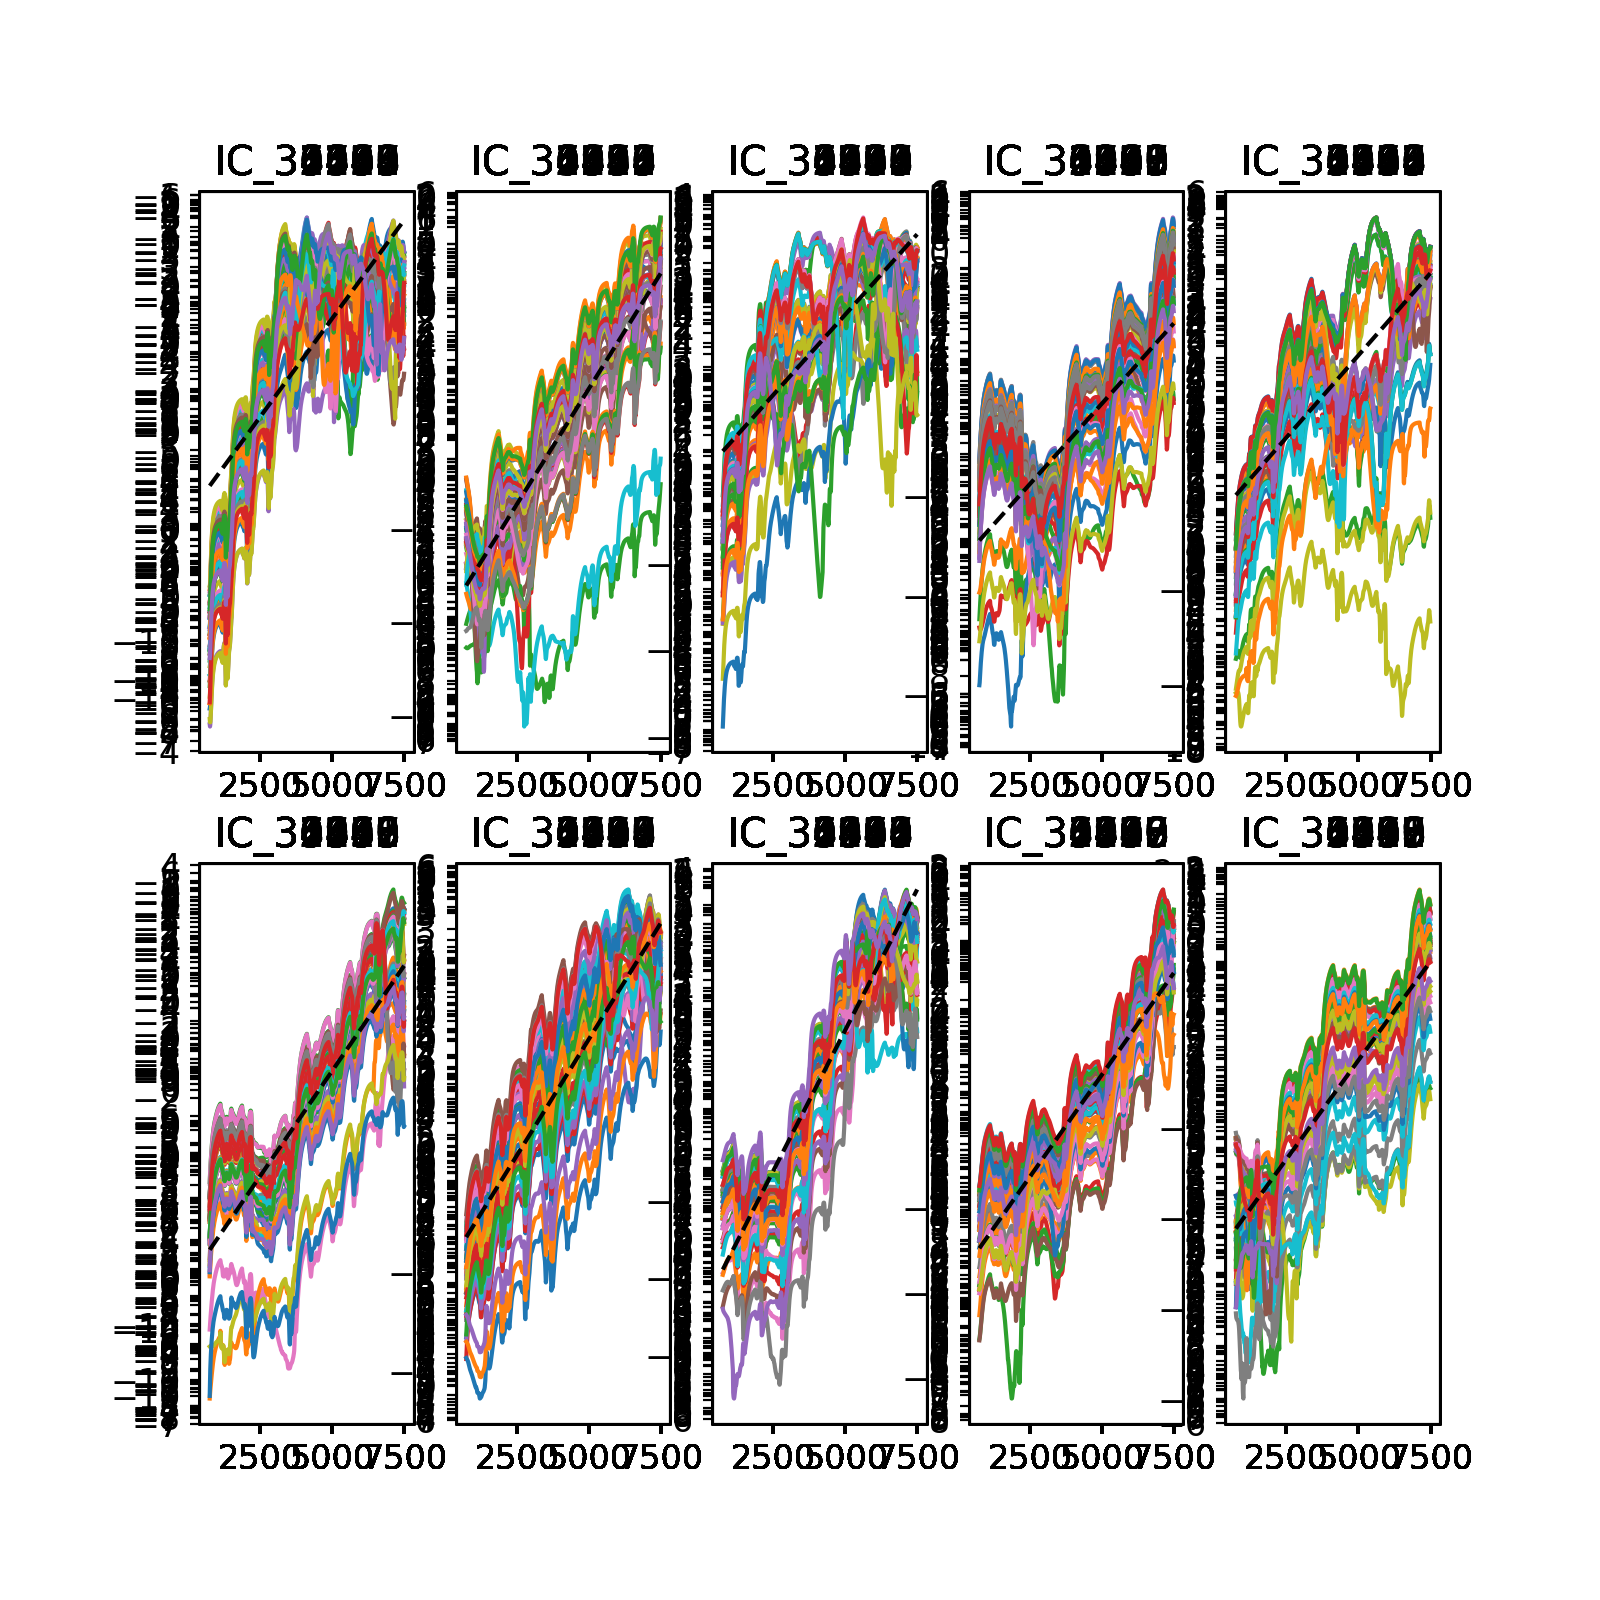

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:01, 36.17it/s]

Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:00, 35.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 32.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 32.56it/s]

Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 33.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 34.45it/s]

Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 34.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 35.22it/s]

Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.27it/s]

Attribute not found


100%|██████████| 45/45 [00:01<00:00, 34.62it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.99it/s]

# Optimal param:	[-1.41101995e-04 -4.06497782e+00]
# Sigma:	[1.03611376e-05 1.30084426e-01]
# Chi-square value: 	340.76483504455155
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 29%|██▉       | 13/45 [00:00<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.39it/s]

# Optimal param:	[-1.43914277e-04 -3.57410868e+00]
# Sigma:	[9.88367480e-06 1.14427667e-01]
# Chi-square value: 	516.219264196146
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.75it/s]

# Optimal param:	[-1.71537225e-04 -3.62085241e+00]
# Sigma:	[1.11791974e-05 1.05084349e-01]
# Chi-square value: 	1226.2864188900146
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 39.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 40.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.98it/s]

# Optimal param:	[-1.56853028e-04 -3.67694506e+00]
# Sigma:	[9.87512382e-06 1.21662588e-01]
# Chi-square value: 	569.4423567237457
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.19it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.65it/s]

# Optimal param:	[-1.25633629e-04 -4.25704095e+00]
# Sigma:	[1.15599033e-05 1.02522144e-01]
# Chi-square value: 	349.86385300582447
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 40.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.57442161e-04 -3.56705768e+00]
# Sigma:	[1.03643057e-05 1.33452449e-01]
# Chi-square value: 	509.63181427655616
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 36.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.48it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.71it/s]

# Optimal param:	[-1.49412447e-04 -3.84606841e+00]
# Sigma:	[1.04599278e-05 1.02419640e-01]
# Chi-square value: 	590.4484100668303
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 31%|███       | 14/45 [00:00<00:00, 39.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 39.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.18it/s]

# Optimal param:	[-1.42262889e-04 -3.85129452e+00]
# Sigma:	[1.08342258e-05 1.17412672e-01]
# Chi-square value: 	483.8440723213778
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 40.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.32it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.56523032e-04 -3.58491434e+00]
# Sigma:	[1.03333972e-05 1.21998462e-01]
# Chi-square value: 	505.2106655753813
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 39.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-1.60031942e-04 -3.96260959e+00]
# Sigma:	[1.08529783e-05 1.58147165e-01]
# Chi-square value: 	341.3495731682887


  2%|▎         | 1/40 [00:31<20:17, 31.22s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


  9%|▉         | 4/45 [00:00<00:01, 32.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:01, 27.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:00, 31.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 35.44it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.79it/s]

# Optimal param:	[ 7.02225209e-04 -2.70134649e+00]
# Sigma:	[3.4695851e-05 2.4310673e-01]
# Chi-square value: 	9905.538403870916
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 36.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.78it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.21it/s]

# Optimal param:	[ 6.28873030e-04 -2.49547085e+00]
# Sigma:	[2.87719352e-05 1.69583407e-01]
# Chi-square value: 	11821.269774419588
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.87it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.84it/s]

# Optimal param:	[ 7.94368692e-04 -3.22353027e+00]
# Sigma:	[2.79088000e-05 1.86501645e-01]
# Chi-square value: 	13582.196220594775
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 40.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 40.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 39.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.64it/s]

# Optimal param:	[ 7.94610997e-04 -4.33738909e+00]
# Sigma:	[1.72146623e-05 1.64876316e-01]
# Chi-square value: 	9606.761706102892
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 41.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 40.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.14it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.06it/s]

# Optimal param:	[ 6.53834598e-04 -3.26521488e+00]
# Sigma:	[1.87731080e-05 1.55190367e-01]
# Chi-square value: 	6523.379781436166
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 35.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.52it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.59it/s]

# Optimal param:	[ 7.51264017e-04 -4.79195160e+00]
# Sigma:	[1.00714593e-05 1.69113184e-01]
# Chi-square value: 	2817.0499199106766
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 35.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.98it/s]

# Optimal param:	[ 5.39867537e-04 -4.90706521e+00]
# Sigma:	[2.68439024e-05 1.59443906e-01]
# Chi-square value: 	8669.093561161131
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.71it/s]

# Optimal param:	[ 4.30136954e-04 -3.86839129e+00]
# Sigma:	[5.09363456e-05 1.83263080e-01]
# Chi-square value: 	18361.582121012783
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.42it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.02it/s]

# Optimal param:	[ 5.51814281e-04 -1.49388047e+00]
# Sigma:	[2.87725864e-05 2.02560784e-01]
# Chi-square value: 	24021.238732251586
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 34.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 34.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 35.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.59it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 8.15406102e-04 -3.52448856e+00]
# Sigma:	[3.36092020e-05 1.98267194e-01]
# Chi-square value: 	8068.500551101112


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 22%|██▏       | 10/45 [00:00<00:00, 40.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:00, 38.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:01<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.23it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 40.00it/s]

# Optimal param:	[-1.29794929e-04 -3.59681959e+00]
# Sigma:	[1.41098284e-05 7.47220263e-02]
# Chi-square value: 	1023.3556315209992
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.57it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.30it/s]

# Optimal param:	[-1.01663980e-04 -3.40815278e+00]
# Sigma:	[1.38764639e-05 7.33116340e-02]
# Chi-square value: 	422.8883276480345
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 39.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.30it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.68it/s]

# Optimal param:	[-6.74891275e-05 -3.67542190e+00]
# Sigma:	[1.00292142e-05 1.34739183e-01]
# Chi-square value: 	50.053112709765614
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 37.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.53it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.37it/s]

# Optimal param:	[-5.38087791e-05 -3.66712807e+00]
# Sigma:	[9.93312882e-06 1.14106154e-01]
# Chi-square value: 	67.1598294430996
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-7.31869805e-05 -3.49114300e+00]
# Sigma:	[1.27929861e-05 9.12390176e-02]
# Chi-square value: 	121.43032042348648
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found



 13%|█▎        | 6/45 [00:00<00:01, 27.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:00, 33.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 35.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 37.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.38it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-9.10998741e-05 -3.84540672e+00]
# Sigma:	[1.33121107e-05 1.05175128e-01]
# Chi-square value: 	165.51855831678006
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 36.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 39.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.97it/s]

# Optimal param:	[-6.98348985e-05 -3.32882848e+00]
# Sigma:	[1.33173199e-05 7.96342474e-02]
# Chi-square value: 	164.65703174613864
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 34.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.29it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.99it/s]

# Optimal param:	[-7.86478622e-05 -3.81668289e+00]
# Sigma:	[1.05563309e-05 1.00295420e-01]
# Chi-square value: 	335.00020693334613
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 35.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.38it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.69it/s]

# Optimal param:	[-7.96920299e-05 -3.42082946e+00]
# Sigma:	[1.01763665e-05 9.37560880e-02]
# Chi-square value: 	101.28373996623151
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 33.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 33.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 34.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 34.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 34.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.25it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-1.09199654e-04 -3.71809097e+00]
# Sigma:	[1.25479747e-05 7.94843130e-02]
# Chi-square value: 	537.891701853625


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.00it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.79it/s]

# Optimal param:	[-4.81543214e-04 -3.25994607e+00]
# Sigma:	[1.78557890e-05 9.54973327e-02]
# Chi-square value: 	3733.0150557979177
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.15it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.70it/s]

# Optimal param:	[-4.15020323e-04 -3.59674245e+00]
# Sigma:	[1.22612479e-05 1.09423321e-01]
# Chi-square value: 	2640.791294715439
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.38it/s]

# Optimal param:	[-4.22710631e-04 -3.22334248e+00]
# Sigma:	[1.6061064e-05 8.8305555e-02]
# Chi-square value: 	3370.8125538647755
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 39.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.84it/s]

# Optimal param:	[-4.54286775e-04 -3.39739430e+00]
# Sigma:	[1.81873575e-05 8.04769080e-02]
# Chi-square value: 	3583.8985797813966
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 40.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.76it/s]

# Optimal param:	[-4.31591102e-04 -3.29054460e+00]
# Sigma:	[1.86097751e-05 8.82896692e-02]
# Chi-square value: 	3127.7676640721343
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 39.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.04it/s]

# Optimal param:	[-4.13929504e-04 -3.34874009e+00]
# Sigma:	[1.67523830e-05 9.37926955e-02]
# Chi-square value: 	4315.722962335316
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 38.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.91it/s]

# Optimal param:	[-4.35565164e-04 -3.49421880e+00]
# Sigma:	[1.72044733e-05 1.09485779e-01]
# Chi-square value: 	2665.674671022399
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.71it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.97it/s]

# Optimal param:	[-5.06690322e-04 -3.13635154e+00]
# Sigma:	[1.71848498e-05 9.52538926e-02]
# Chi-square value: 	3945.588528932797
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 35.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.95it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-4.19377930e-04 -3.64764482e+00]
# Sigma:	[1.49477410e-05 1.12682956e-01]
# Chi-square value: 	3166.7777150353722
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 35.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.28it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-4.56099648e-04 -3.62185021e+00]
# Sigma:	[2.20530385e-05 1.19935106e-01]
# Chi-square value: 	2125.103531409524


 10%|█         | 4/40 [02:06<19:02, 31.74s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************



 11%|█         | 5/45 [00:00<00:00, 41.30it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attrib


 31%|███       | 14/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 38.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 36.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.95it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.88479123e-04 -3.33197502e+00]
# Sigma:	[6.59181542e-06 1.31548365e-01]
# Chi-square value: 	4047.1320285156544
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.21it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.21it/s]

# Optimal param:	[-1.72871943e-04 -2.82205080e+00]
# Sigma:	[6.31701448e-06 1.31924018e-01]
# Chi-square value: 	7387.347542428405
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.15it/s]

# Optimal param:	[-1.89498717e-04 -2.89377094e+00]
# Sigma:	[8.69514889e-06 1.45710489e-01]
# Chi-square value: 	6119.3753365173825
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 40.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.94it/s]

# Optimal param:	[-1.92802703e-04 -2.92652157e+00]
# Sigma:	[3.58415744e-06 1.28198979e-01]
# Chi-square value: 	6090.73864627772
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 39.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.74it/s]

# Optimal param:	[-1.93977015e-04 -2.88967238e+00]
# Sigma:	[9.62829486e-06 1.47579889e-01]
# Chi-square value: 	5924.365805399675
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 39.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 36.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 27.17it/s]

# Optimal param:	[-1.79703177e-04 -2.84250250e+00]
# Sigma:	[4.29338436e-06 1.12549374e-01]
# Chi-square value: 	8078.766693794038
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.10it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.76it/s]

# Optimal param:	[-1.87849610e-04 -2.86070919e+00]
# Sigma:	[7.06389574e-06 1.10025354e-01]
# Chi-square value: 	8548.388495436497
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 39.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.20it/s]

# Optimal param:	[-2.01382958e-04 -3.28015460e+00]
# Sigma:	[7.44491859e-06 1.32358518e-01]
# Chi-square value: 	4318.256438446412
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.58it/s]

# Optimal param:	[-1.94838197e-04 -2.95959930e+00]
# Sigma:	[3.75124329e-06 1.24958547e-01]
# Chi-square value: 	6610.25972602784
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 27%|██▋       | 12/45 [00:00<00:00, 35.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.14it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-1.87958223e-04 -2.84129661e+00]
# Sigma:	[7.52757221e-06 1.15742261e-01]
# Chi-square value: 	7104.77579605031


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 39.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.19it/s]

# Optimal param:	[ 1.67743209e-04 -3.35527106e+00]
# Sigma:	[1.57230307e-05 1.28363480e-01]
# Chi-square value: 	4604.883473277047
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 41.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.95it/s]

# Optimal param:	[ 3.47489744e-04 -2.97982305e+00]
# Sigma:	[9.63056391e-06 1.57622748e-01]
# Chi-square value: 	2436.6458372175857
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.35it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.69it/s]

# Optimal param:	[ 4.13346942e-04 -3.06127946e+00]
# Sigma:	[1.37919153e-05 1.41675568e-01]
# Chi-square value: 	11068.147380334129
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.60it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.84it/s]

# Optimal param:	[ 3.52283724e-05 -2.92401232e+00]
# Sigma:	[3.60401142e-05 1.43865154e-01]
# Chi-square value: 	4014.113549502276
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.87it/s]

# Optimal param:	[ 5.98173165e-05 -1.08165278e+00]
# Sigma:	[1.93449048e-06 1.29339523e-01]
# Chi-square value: 	13476.944131826902
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.30it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.96it/s]

# Optimal param:	[ 2.61735389e-04 -4.20684566e+00]
# Sigma:	[1.85451104e-05 8.52975321e-02]
# Chi-square value: 	5642.819688455358
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 39.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.41it/s]

# Optimal param:	[ 4.11567567e-04 -3.13173241e+00]
# Sigma:	[2.06164108e-06 1.48605392e-01]
# Chi-square value: 	7457.561348194604
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 35.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.53it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.71it/s]

# Optimal param:	[ 3.66119285e-04 -2.72200706e+00]
# Sigma:	[3.36949514e-06 2.07313938e-01]
# Chi-square value: 	1825.068433751577
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[ 3.54421917e-04 -2.49333069e+00]
# Sigma:	[1.82546766e-06 1.11551813e-01]
# Chi-square value: 	5071.14754320569
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo

 13%|█▎        | 6/45 [00:00<00:01, 26.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.18it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 1.80711074e-04 -3.47029179e+00]
# Sigma:	[3.40153486e-05 1.27980351e-01]
# Chi-square value: 	8171.853323917307


 18%|█▊        | 7/40 [03:11<14:17, 25.98s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************



 11%|█         | 5/45 [00:00<00:00, 41.49it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attrib


 31%|███       | 14/45 [00:00<00:00, 37.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 37.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 36.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.49it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.33it/s]

# Optimal param:	[-5.68114010e-05 -3.44632562e+00]
# Sigma:	[1.24842607e-05 1.24688602e-01]
# Chi-square value: 	35.13036615911521
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 18%|█▊        | 8/45 [00:00<00:01, 33.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 31.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 34.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.66it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.42it/s]

# Optimal param:	[-5.91108440e-05 -3.43379517e+00]
# Sigma:	[1.33428586e-05 1.06044558e-01]
# Chi-square value: 	35.18585264735857
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.42it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.86it/s]

# Optimal param:	[-3.93964872e-05 -3.89884645e+00]
# Sigma:	[9.81073720e-06 1.11873244e-01]
# Chi-square value: 	42.385485043284746
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 36.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 33.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 34.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 35.55it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.54it/s]

# Optimal param:	[-2.58627491e-05 -3.60921500e+00]
# Sigma:	[3.58215316e-06 1.22997670e-01]
# Chi-square value: 	101.68117256824257
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 40.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.37it/s]

# Optimal param:	[-4.29498625e-05 -3.54590758e+00]
# Sigma:	[8.13260114e-06 9.45903105e-02]
# Chi-square value: 	165.29231553624976
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.71it/s]

# Optimal param:	[-7.03149585e-05 -3.81782279e+00]
# Sigma:	[1.45464890e-05 1.00275368e-01]
# Chi-square value: 	49.38826669262845
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 39.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.57it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.40it/s]

# Optimal param:	[-5.52883967e-05 -3.52525155e+00]
# Sigma:	[1.15153311e-05 7.62756337e-02]
# Chi-square value: 	37.129475769567534
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.40it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.40it/s]

# Optimal param:	[-7.55363533e-05 -3.46453531e+00]
# Sigma:	[1.59709702e-05 1.00383558e-01]
# Chi-square value: 	62.986348554545174
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 34.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 36.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.45it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.12it/s]

# Optimal param:	[-3.11076960e-05 -3.41013707e+00]
# Sigma:	[9.30509013e-06 1.11723207e-01]
# Chi-square value: 	47.3753671551901
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 27%|██▋       | 12/45 [00:00<00:00, 35.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.77it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-7.43152910e-05 -3.43368648e+00]
# Sigma:	[1.59062730e-05 1.01485002e-01]
# Chi-square value: 	29.79029506446168


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute no


 18%|█▊        | 8/45 [00:00<00:00, 37.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 39.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.87it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.79it/s]

# Optimal param:	[ 5.74289668e-04 -2.70986442e+00]
# Sigma:	[1.10867470e-05 9.57753696e-02]
# Chi-square value: 	6564.505565673184
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 38.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 35.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.04it/s]

# Optimal param:	[ 4.05439286e-04 -2.49128560e+00]
# Sigma:	[3.72987413e-05 1.71798572e-01]
# Chi-square value: 	12599.241658820274
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 35.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.32it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.38it/s]

# Optimal param:	[ 1.01685717e-03 -2.28291588e+00]
# Sigma:	[1.65926491e-05 1.66262899e-01]
# Chi-square value: 	11749.411933920954
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 33.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.71it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 1.11250233e-03 -4.15421942e+00]
# Sigma:	[1.75945482e-05 2.07920396e-01]
# Chi-square value: 	12296.750723250218
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 34.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.43it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.99it/s]

# Optimal param:	[ 3.79553091e-04 -2.88025645e+00]
# Sigma:	[7.08681409e-06 1.49235968e-01]
# Chi-square value: 	3475.49814057852
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 18%|█▊        | 8/45 [00:00<00:01, 32.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 33.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 34.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.69it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.30it/s]

# Optimal param:	[ 8.25624635e-04 -3.70945403e+00]
# Sigma:	[2.48891037e-05 1.06789007e-01]
# Chi-square value: 	7178.374341770355
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.69it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.62it/s]

# Optimal param:	[ 9.44387705e-04 -2.91195375e+00]
# Sigma:	[3.06272182e-05 1.36555249e-01]
# Chi-square value: 	18070.94334307885
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 35.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.63it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.44it/s]

# Optimal param:	[ 5.80977602e-04 -3.42054270e+00]
# Sigma:	[7.45217623e-06 1.95612580e-01]
# Chi-square value: 	2914.056217077464
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 8.77372291e-04 -3.60966498e+00]
# Sigma:	[5.58194175e-06 1.55493284e-01]
# Chi-square value: 	24949.740208653242
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 35.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.74it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 8.04300788e-04 -3.52931289e+00]
# Sigma:	[7.91989136e-06 1.14247444e-01]
# Chi-square value: 	9737.37007619772


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.42it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.87it/s]

# Optimal param:	[ 5.58393994e-04 -4.09197975e+00]
# Sigma:	[2.37988914e-05 1.22003054e-01]
# Chi-square value: 	12846.64023792871
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 34.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.22it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 8.62220732e-04 -2.34204551e+00]
# Sigma:	[3.17696848e-05 1.94096391e-01]
# Chi-square value: 	6241.174181731584
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 36.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.94it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.91it/s]

# Optimal param:	[ 6.65079918e-04 -4.41910307e+00]
# Sigma:	[4.39254999e-05 1.11404241e-01]
# Chi-square value: 	23258.255407640165
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.63it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.88it/s]

# Optimal param:	[ 9.39434378e-04 -3.76558052e+00]
# Sigma:	[1.81716506e-05 1.17863911e-01]
# Chi-square value: 	9422.704559986552
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 39.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.40it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 6.88668854e-04 -2.86406300e+00]
# Sigma:	[2.47124657e-05 1.62668189e-01]
# Chi-square value: 	7997.107003164705



 11%|█         | 5/45 [00:00<00:00, 40.67it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:00, 40.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.40it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.95it/s]

# Optimal param:	[ 7.65780155e-04 -3.23770756e+00]
# Sigma:	[7.93618682e-06 1.26294190e-01]
# Chi-square value: 	17993.4136030643
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 31%|███       | 14/45 [00:00<00:00, 39.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 38.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.25it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.79it/s]

# Optimal param:	[ 2.35201879e-04 -3.09538435e+00]
# Sigma:	[1.55660230e-05 1.45872731e-01]
# Chi-square value: 	4677.179750060646
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.60it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.83it/s]

# Optimal param:	[ 8.74214645e-04 -3.27597955e+00]
# Sigma:	[1.08748220e-05 1.54069971e-01]
# Chi-square value: 	6188.743569125316
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:00, 36.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 36.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.36it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.72it/s]

# Optimal param:	[ 1.04250279e-03 -3.29173271e+00]
# Sigma:	[1.97115570e-05 1.77765512e-01]
# Chi-square value: 	6987.02066308828
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 27%|██▋       | 12/45 [00:00<00:00, 37.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.76it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 7.91291544e-04 -2.65439834e+00]
# Sigma:	[1.94199436e-05 1.49823236e-01]
# Chi-square value: 	21839.355236220817


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


  9%|▉         | 4/45 [00:00<00:02, 19.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 16%|█▌        | 7/45 [00:00<00:01, 19.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 29%|██▉       | 13/45 [00:00<00:01, 19.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:01, 18.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:01<00:01, 19.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:01<00:00, 18.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 18.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 17.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:02<00:00, 17.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.41it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[-5.58784874e-06 -4.57052794e-01]
# Sigma:	[4.12392658e-06 1.36109042e-01]
# Chi-square value: 	2150.252291197219
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 13%|█▎        | 6/45 [00:00<00:01, 19.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 18.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 18.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:01<00:01, 18.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:01, 18.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 18.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:02<00:00, 18.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.73it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.55331127e-04 -3.36096342e+00]
# Sigma:	[2.62571759e-05 1.01277023e-01]
# Chi-square value: 	3675.7146286568004
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 11%|█         | 5/45 [00:00<00:02, 19.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 19.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:01<00:01, 18.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:01, 18.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 18.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 18.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:02<00:00, 18.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.58it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.92it/s]

# Optimal param:	[-9.65119704e-06 -1.02365873e+00]
# Sigma:	[4.91720069e-06 1.86241624e-01]
# Chi-square value: 	1182.0375290652405
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 16%|█▌        | 7/45 [00:00<00:01, 20.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:01, 19.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 19.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:01<00:01, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:01, 18.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 18.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 18.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:02<00:00, 18.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 17.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.64it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 17.88it/s]

# Optimal param:	[-3.17062939e-05 -8.38119999e-01]
# Sigma:	[1.23126210e-05 1.45345789e-01]
# Chi-square value: 	1339.9861714881802
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 18.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:01, 19.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:01<00:01, 18.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:01<00:00, 18.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:01<00:00, 18.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 18.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:02<00:00, 18.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:02<00:00, 17.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.55it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.01649315e-04 -3.30048679e+00]
# Sigma:	[2.51478930e-05 1.10142519e-01]
# Chi-square value: 	4807.554625312838
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 17.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 20%|██        | 9/45 [00:00<00:01, 18.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 19.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:01<00:01, 19.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:01<00:00, 19.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 19.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 19.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:02<00:00, 19.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:02<00:00, 18.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.90it/s]


<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 18.40it/s]

# Optimal param:	[-1.57103127e-04 -3.47144086e+00]
# Sigma:	[2.83215212e-05 1.22710758e-01]
# Chi-square value: 	4537.877281444872
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 16%|█▌        | 7/45 [00:00<00:01, 19.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 19.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:01<00:01, 19.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:01<00:00, 19.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:01<00:00, 18.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 19.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:02<00:00, 18.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:02<00:00, 18.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:02<00:00, 19.01it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-4.89190315e-05 -4.46910403e-01]
# Sigma:	[1.07597037e-05 1.49450841e-01]
# Chi-square value: 	1330.6458511353283
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 13%|█▎        | 6/45 [00:00<00:01, 20.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:01, 20.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 20.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 20.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:01<00:00, 19.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 19.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 19.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:02<00:00, 19.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.58it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-7.86285139e-05 -3.17762151e+00]
# Sigma:	[1.71007665e-05 1.15137179e-01]
# Chi-square value: 	2113.691738755279
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 13%|█▎        | 6/45 [00:00<00:01, 20.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:01, 19.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 20.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 20.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 19.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:01<00:00, 19.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 19.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:02<00:00, 19.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.37it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-6.50284470e-05 -3.35188684e+00]
# Sigma:	[2.32136759e-05 1.00905249e-01]
# Chi-square value: 	1654.969322451535
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 13%|█▎        | 6/45 [00:00<00:01, 20.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:01, 19.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 20.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 20.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:01<00:00, 19.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:01<00:00, 19.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 18.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:02<00:00, 18.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.27it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 2.76749120e-06 -6.30784618e-01]
# Sigma:	[4.13677580e-06 1.63973401e-01]
# Chi-square value: 	1592.5814409687516


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 20%|██        | 9/45 [00:00<00:00, 39.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.82it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.71it/s]

# Optimal param:	[-2.81202084e-04 -3.44134750e+00]
# Sigma:	[1.40341983e-05 1.22814669e-01]
# Chi-square value: 	1211.107365043971
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.42it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.78it/s]

# Optimal param:	[-3.05050072e-04 -2.80415176e+00]
# Sigma:	[9.38103919e-06 1.11907636e-01]
# Chi-square value: 	2254.794029858262
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.72it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.70it/s]

# Optimal param:	[-2.79997658e-04 -3.10291113e+00]
# Sigma:	[1.49179763e-05 1.42816732e-01]
# Chi-square value: 	1514.638120203921
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 41.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 39.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.56it/s]

# Optimal param:	[-3.06513240e-04 -3.04626671e+00]
# Sigma:	[1.17536804e-05 8.58405357e-02]
# Chi-square value: 	2121.5028281017235
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 41.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 40.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.58it/s]

# Optimal param:	[-3.19693522e-04 -2.96332866e+00]
# Sigma:	[7.57593408e-06 8.89674758e-02]
# Chi-square value: 	2992.803945515696
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 39.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 38.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.28it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.09it/s]

# Optimal param:	[-2.84429170e-04 -2.99188633e+00]
# Sigma:	[1.55896696e-05 1.53603180e-01]
# Chi-square value: 	2417.8409097477097
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 34.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.44it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-2.77319153e-04 -3.11909122e+00]
# Sigma:	[1.27932523e-05 1.26304142e-01]
# Chi-square value: 	3482.860448720693
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 35.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.81it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.15it/s]

# Optimal param:	[-3.09443054e-04 -2.90856370e+00]
# Sigma:	[1.20903212e-05 1.13608367e-01]
# Chi-square value: 	3343.0562026247194
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 29%|██▉       | 13/45 [00:00<00:00, 40.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 40.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 39.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 39.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.37it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.94it/s]

# Optimal param:	[-3.06447839e-04 -3.30273573e+00]
# Sigma:	[1.45193989e-05 1.17120712e-01]
# Chi-square value: 	2083.7596645193544
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 29%|██▉       | 13/45 [00:00<00:00, 40.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 39.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.49it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-3.10008824e-04 -3.11345178e+00]
# Sigma:	[1.38711535e-05 1.14649271e-01]
# Chi-square value: 	1892.5780740349437


 32%|███▎      | 13/40 [06:14<13:55, 30.96s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************



 11%|█         | 5/45 [00:00<00:00, 41.96it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attrib


 33%|███▎      | 15/45 [00:00<00:00, 40.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.30it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 62%|██████▏   | 28/45 [00:00<00:00, 39.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.94it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.41it/s]

# Optimal param:	[6.98697647e-05 3.64353327e+00]
# Sigma:	[2.27407510e-05 1.21149477e-01]
# Chi-square value: 	2371.2425804452655
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 41.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 39.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.31it/s]

# Optimal param:	[4.00628765e-05 3.93815669e+00]
# Sigma:	[2.19875967e-05 1.25653511e-01]
# Chi-square value: 	2606.0168976979094
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 41.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 39.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.78it/s]

# Optimal param:	[4.42732768e-04 6.08548557e-01]
# Sigma:	[4.47894182e-05 3.10932370e-01]
# Chi-square value: 	5149.225579779614
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 24%|██▍       | 11/45 [00:00<00:00, 36.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.83it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.47it/s]

# Optimal param:	[4.69190823e-04 1.14137272e+00]
# Sigma:	[3.44018147e-05 1.89093965e-01]
# Chi-square value: 	5795.840293290419
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 29%|██▉       | 13/45 [00:00<00:00, 39.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 37.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.54it/s]

# Optimal param:	[2.98850040e-04 2.17568695e+00]
# Sigma:	[3.33287334e-05 1.97901480e-01]
# Chi-square value: 	4697.492307136405
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 22%|██▏       | 10/45 [00:00<00:00, 40.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 40.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 38.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.98it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 32.58it/s]

# Optimal param:	[ 5.04821909e-04 -1.80375162e+00]
# Sigma:	[1.20832775e-05 8.86443883e-02]
# Chi-square value: 	9284.481371601616
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 38.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 39.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 39.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.25it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[5.19975662e-04 6.81938482e-01]
# Sigma:	[3.91214666e-05 2.18220410e-01]
# Chi-square value: 	9057.535187541658
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 20%|██        | 9/45 [00:00<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 39.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 25.65it/s]

# Optimal param:	[1.50643827e-04 2.90800549e+00]
# Sigma:	[2.92593981e-05 2.14033323e-01]
# Chi-square value: 	948.3755715059974
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 24%|██▍       | 11/45 [00:00<00:01, 33.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 28.74it/s]

# Optimal param:	[2.03329043e-04 4.92050887e-01]
# Sigma:	[3.79877407e-05 1.68694167e-01]
# Chi-square value: 	4896.629212598458
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.41it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[4.73573476e-04 5.35355956e-01]
# Sigma:	[3.51827019e-05 1.97040259e-01]
# Chi-square value: 	14564.59650103743


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 39.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 38.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.81it/s]

# Optimal param:	[-1.02376376e-03  3.41290175e+00]
# Sigma:	[6.65421638e-06 1.40446323e-01]
# Chi-square value: 	9227.777639208478
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.10it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.71it/s]

# Optimal param:	[-1.01992564e-03  3.83985777e+00]
# Sigma:	[6.33111398e-06 1.61086776e-01]
# Chi-square value: 	4385.178556549073
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.99it/s]

# Optimal param:	[-9.92990725e-04  3.46720931e+00]
# Sigma:	[1.25363994e-05 1.84934659e-01]
# Chi-square value: 	5582.856917860403
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 41.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 40.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 39.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 39.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.22it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.80it/s]

# Optimal param:	[-1.03486839e-03  3.35286650e+00]
# Sigma:	[8.18755026e-06 1.56610532e-01]
# Chi-square value: 	4978.409355700091
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.24it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.42it/s]

# Optimal param:	[-1.01363178e-03  3.97877950e+00]
# Sigma:	[9.08958168e-06 1.56212082e-01]
# Chi-square value: 	4025.0539195932515
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 29%|██▉       | 13/45 [00:00<00:00, 40.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 40.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.64it/s]

# Optimal param:	[-1.02172582e-03  3.77789665e+00]
# Sigma:	[5.10733023e-06 1.28064155e-01]
# Chi-square value: 	9141.047234287478
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.87it/s]

# Optimal param:	[-1.01115202e-03  3.79967907e+00]
# Sigma:	[7.47084724e-06 1.32885450e-01]
# Chi-square value: 	9413.42466805295
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 29%|██▉       | 13/45 [00:00<00:00, 39.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.31it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.80it/s]

# Optimal param:	[-9.89891039e-04  3.03067910e+00]
# Sigma:	[1.06168584e-05 1.72966882e-01]
# Chi-square value: 	4752.8645962863
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 22%|██▏       | 10/45 [00:00<00:00, 40.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 31.83it/s]

# Optimal param:	[-1.02925463e-03  4.32463766e+00]
# Sigma:	[9.15746382e-06 2.02094318e-01]
# Chi-square value: 	1317.5743691113562
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 39.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.40it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-9.79163458e-04  3.00057009e+00]
# Sigma:	[1.23441648e-05 1.89991336e-01]
# Chi-square value: 	5840.818649387813


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 22%|██▏       | 10/45 [00:00<00:00, 39.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.76it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.93it/s]

# Optimal param:	[-2.35331352e-04 -1.04412605e+00]
# Sigma:	[7.33797630e-06 1.14199639e-01]
# Chi-square value: 	18418.98023745692
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 39.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 39.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.29it/s]

# Optimal param:	[-8.31406694e-05 -2.33989102e+00]
# Sigma:	[1.53823016e-05 1.01924237e-01]
# Chi-square value: 	11765.633170615143
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 41.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.03it/s]

# Optimal param:	[-2.25402839e-04 -1.45921045e+00]
# Sigma:	[1.03043911e-05 1.55485546e-01]
# Chi-square value: 	10715.196291777911
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 29%|██▉       | 13/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.27it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.08it/s]

# Optimal param:	[-1.89256835e-04 -1.47207986e+00]
# Sigma:	[2.10023478e-05 1.99365053e-01]
# Chi-square value: 	10005.574685088071
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.26it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 38.43it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.23865903e-04 -2.96939008e+00]
# Sigma:	[2.88196717e-05 1.90340083e-01]
# Chi-square value: 	12449.44192062026
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 36.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.21it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.47it/s]

# Optimal param:	[-5.13588857e-05 -2.41370405e+00]
# Sigma:	[1.11336187e-05 9.78619400e-02]
# Chi-square value: 	21431.663856664323
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 40.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.11it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.48it/s]

# Optimal param:	[-2.62388139e-04 -1.68675151e+00]
# Sigma:	[1.37905703e-05 1.38982449e-01]
# Chi-square value: 	17414.138264387817
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 41.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 39.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 39.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.87it/s]

# Optimal param:	[-6.92817060e-05 -2.68189251e+00]
# Sigma:	[1.42832139e-05 9.99435055e-02]
# Chi-square value: 	18842.090608687125
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.32it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.99it/s]

# Optimal param:	[-2.79680894e-05 -2.31582212e+00]
# Sigma:	[9.63310928e-06 9.40670102e-02]
# Chi-square value: 	17962.894932394942
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.54it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-1.76793638e-04 -2.13045322e+00]
# Sigma:	[1.73751373e-05 1.59657370e-01]
# Chi-square value: 	12310.389487804277


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 20%|██        | 9/45 [00:00<00:00, 39.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.67it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.32it/s]

# Optimal param:	[ 2.93545459e-05 -1.30201434e+00]
# Sigma:	[8.12435327e-06 1.28222576e-01]
# Chi-square value: 	36345.51721946437
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.71it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.12it/s]

# Optimal param:	[-8.34118710e-06 -1.26280573e+00]
# Sigma:	[2.86114589e-06 1.54233961e-01]
# Chi-square value: 	17686.824766724698
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 35.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 34.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.94it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.03it/s]

# Optimal param:	[ 6.50084167e-05 -1.63617700e+00]
# Sigma:	[2.32313295e-05 1.54994732e-01]
# Chi-square value: 	6649.974447753624
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.94it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 4.59544627e-04 -1.47604859e+00]
# Sigma:	[1.02274774e-05 1.70125879e-01]
# Chi-square value: 	13029.156378757478



 11%|█         | 5/45 [00:00<00:00, 40.37it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attrib


 33%|███▎      | 15/45 [00:00<00:00, 40.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.80it/s]

# Optimal param:	[3.42043472e-04 1.94839042e+00]
# Sigma:	[3.23130527e-05 2.25319521e-01]
# Chi-square value: 	1947.6042140923016
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 27%|██▋       | 12/45 [00:00<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 44%|████▍     | 20/45 [00:00<00:00, 37.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.13it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 44.61it/s]

# Optimal param:	[ 1.96526764e-04 -1.69327157e+00]
# Sigma:	[6.91561168e-06 1.84674696e-01]
# Chi-square value: 	15839.910338416994
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 33%|███▎      | 15/45 [00:00<00:00, 44.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 46.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 52.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:00<00:00, 52.50it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 33.17it/s]

# Optimal param:	[3.14633968e-04 1.36974983e+00]
# Sigma:	[3.35396720e-05 1.67246668e-01]
# Chi-square value: 	1216.607439681763
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 34.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 56%|█████▌    | 25/45 [00:00<00:00, 38.08it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.73it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.87it/s]

# Optimal param:	[ 2.90724674e-04 -2.78743552e+00]
# Sigma:	[1.06641016e-05 1.92357974e-01]
# Chi-square value: 	13928.82744180807
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 29%|██▉       | 13/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.68it/s]

# Optimal param:	[ 3.68111445e-05 -1.52189010e+00]
# Sigma:	[5.45874662e-06 1.83928425e-01]
# Chi-square value: 	7541.946942298998
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 7.32579349e-04 -1.12218078e+00]
# Sigma:	[2.50065471e-05 1.50019939e-01]
# Chi-square value: 	12912.048730290297


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:01, 35.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.74it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.92it/s]

# Optimal param:	[ 1.66244545e-05 -4.02243817e+00]
# Sigma:	[8.05629463e-06 9.32551263e-02]
# Chi-square value: 	6608.232238202529
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.73it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.39it/s]

# Optimal param:	[ 1.57624302e-05 -3.97721935e+00]
# Sigma:	[9.61662041e-06 1.04586564e-01]
# Chi-square value: 	5647.4705498369885
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found

100%|██████████| 45/45 [00:01<00:00, 36.93it/s]



<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.82it/s]

# Optimal param:	[ 7.71234804e-06 -3.94940369e+00]
# Sigma:	[1.11622938e-05 9.48399869e-02]
# Chi-square value: 	4087.2933633757802
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.89it/s]


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.51it/s]

# Optimal param:	[ 8.75951502e-06 -3.81540145e+00]
# Sigma:	[9.63881395e-06 9.86742297e-02]
# Chi-square value: 	3773.7380042187424
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 36.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.72it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.80it/s]

# Optimal param:	[ 3.18039976e-05 -3.68146422e+00]
# Sigma:	[5.41828735e-06 1.27199802e-01]
# Chi-square value: 	4198.391911925904
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:01, 30.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 36.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 35.79it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.66it/s]

# Optimal param:	[ 3.05762098e-05 -3.97247167e+00]
# Sigma:	[6.85708863e-06 1.18507366e-01]
# Chi-square value: 	5290.229755796258
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 82%|████████▏ | 37/45 [00:00<00:00, 37.59it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.68it/s]

# Optimal param:	[ 4.64615403e-05 -3.93535952e+00]
# Sigma:	[4.63352674e-06 9.91772987e-02]
# Chi-square value: 	7444.075698237598
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.64it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.31it/s]

# Optimal param:	[ 1.92835162e-05 -3.91858178e+00]
# Sigma:	[8.23693183e-06 1.14504252e-01]
# Chi-square value: 	4142.028416594207
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.60it/s]

# Optimal param:	[ 2.36732818e-05 -4.21771277e+00]
# Sigma:	[8.04479285e-06 8.68434971e-02]
# Chi-square value: 	7525.91399480793
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 24%|██▍       | 11/45 [00:00<00:00, 34.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.00it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 3.59539199e-05 -3.95444983e+00]
# Sigma:	[6.23419666e-06 1.10406702e-01]
# Chi-square value: 	5425.209629764153


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 22%|██▏       | 10/45 [00:00<00:00, 40.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:00, 39.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 39.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 38.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.55it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.56it/s]

# Optimal param:	[-3.99197678e-04 -3.50229834e+00]
# Sigma:	[2.15859800e-05 1.40855327e-01]
# Chi-square value: 	3793.273459034278
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-3.95182573e-04 -3.80155266e+00]
# Sigma:	[2.93360938e-05 1.49507389e-01]
# Chi-square value: 	3633.0455124153905
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:01, 37.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:00, 38.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.66it/s]

# Optimal param:	[-3.73524097e-04 -3.78342533e+00]
# Sigma:	[2.85979128e-05 1.64963076e-01]
# Chi-square value: 	2566.0651855364504
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 39.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.42it/s]


<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.57it/s]

# Optimal param:	[-4.34674868e-04 -3.40777689e+00]
# Sigma:	[1.82855139e-05 1.33536748e-01]
# Chi-square value: 	4720.898207400655
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:01, 33.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 35.81it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.40it/s]

# Optimal param:	[-4.02656729e-04 -3.87701772e+00]
# Sigma:	[2.44998225e-05 1.59155494e-01]
# Chi-square value: 	4131.88878322846
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 27%|██▋       | 12/45 [00:00<00:00, 37.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.05it/s]


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.92it/s]

# Optimal param:	[-2.95625366e-04 -4.10104720e+00]
# Sigma:	[2.01039053e-05 1.35445668e-01]
# Chi-square value: 	2359.9434598712733
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 35.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 35.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.06it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.15it/s]

# Optimal param:	[-2.81353010e-04 -4.22512832e+00]
# Sigma:	[2.08448217e-05 1.35120715e-01]
# Chi-square value: 	3601.2390398784755
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.10it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.36it/s]

# Optimal param:	[-4.12823266e-04 -3.59900055e+00]
# Sigma:	[2.28786968e-05 1.41679282e-01]
# Chi-square value: 	4536.455350590353
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.25it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.26it/s]

# Optimal param:	[-3.44322711e-04 -3.85537533e+00]
# Sigma:	[2.10441346e-05 1.20829887e-01]
# Chi-square value: 	10319.567991352002
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-3.00094263e-04 -4.16837709e+00]
# Sigma:	[2.71102889e-05 1.55321270e-01]
# Chi-square value: 	5257.1058854437415


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 37.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.79it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.49it/s]

# Optimal param:	[-7.00455369e-05 -2.56513856e+00]
# Sigma:	[1.45820203e-05 1.13669227e-01]
# Chi-square value: 	7651.885573935057
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.46it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.81it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.71it/s]

# Optimal param:	[-2.49548691e-04 -3.33017657e+00]
# Sigma:	[2.76382898e-05 1.34498065e-01]
# Chi-square value: 	11116.159463944226
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.87it/s]

# Optimal param:	[-1.30116285e-04 -2.74699577e+00]
# Sigma:	[1.12538427e-05 1.34922890e-01]
# Chi-square value: 	10851.88442621741
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.14it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 34.61it/s]

# Optimal param:	[-1.46739803e-04 -3.61509672e+00]
# Sigma:	[1.53511141e-05 1.08930678e-01]
# Chi-square value: 	12900.016528138964
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 36.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 24.64it/s]

# Optimal param:	[-1.29077674e-04 -2.85224876e+00]
# Sigma:	[9.11600313e-06 1.21477428e-01]
# Chi-square value: 	15103.65605381033
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:01, 32.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 35.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 36.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 36.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 34.94it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 35.40it/s]

# Optimal param:	[-8.34160327e-05 -3.24060752e+00]
# Sigma:	[2.08738241e-05 1.27487721e-01]
# Chi-square value: 	7632.067947819378
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 36.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.62it/s]

# Optimal param:	[-1.20666959e-04 -4.00033742e+00]
# Sigma:	[2.68177333e-05 1.66326893e-01]
# Chi-square value: 	10305.809588364657
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 38.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.20973806e-04 -2.87853684e+00]
# Sigma:	[2.06184805e-05 1.11371565e-01]
# Chi-square value: 	7326.74413569994
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 20%|██        | 9/45 [00:00<00:00, 36.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.21it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.01it/s]

# Optimal param:	[-8.00443664e-05 -3.02234407e+00]
# Sigma:	[1.44146381e-05 1.19656708e-01]
# Chi-square value: 	8615.792715191728
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 41.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-5.02153302e-05 -3.09896611e+00]
# Sigma:	[1.75714237e-05 1.51507913e-01]
# Chi-square value: 	9492.615418163628


 52%|█████▎    | 21/40 [10:18<10:04, 31.80s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************



 11%|█         | 5/45 [00:00<00:00, 42.69it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:00, 38.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.20it/s]

# Optimal param:	[-3.58221700e-04 -4.87367867e+00]
# Sigma:	[2.54818379e-05 1.29558360e-01]
# Chi-square value: 	16250.502222654664
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.95it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.35it/s]

# Optimal param:	[-3.83912524e-04 -4.68718214e+00]
# Sigma:	[3.14113565e-05 1.49329253e-01]
# Chi-square value: 	4671.093809064951
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 18%|█▊        | 8/45 [00:00<00:01, 25.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 32.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 34.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 33.67it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-3.13322580e-04 -4.99040298e+00]
# Sigma:	[2.17214461e-05 1.27928295e-01]
# Chi-square value: 	6413.496277848907
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.12it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.63it/s]

# Optimal param:	[-2.58006296e-04 -5.22184940e+00]
# Sigma:	[2.26454425e-05 1.23017116e-01]
# Chi-square value: 	6593.565299601791
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.98it/s]

# Optimal param:	[-3.51408244e-04 -4.66614052e+00]
# Sigma:	[2.02615231e-05 1.19611173e-01]
# Chi-square value: 	8744.386829769275
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.79it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.75it/s]

# Optimal param:	[-2.95605489e-04 -5.22253457e+00]
# Sigma:	[2.11151899e-05 1.15158606e-01]
# Chi-square value: 	7762.325348786641
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.00it/s]


<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.54it/s]

# Optimal param:	[-2.82580267e-04 -5.13009949e+00]
# Sigma:	[2.50850273e-05 1.38314115e-01]
# Chi-square value: 	6368.556433546824
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:01, 30.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 34.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 35.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 35.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.53it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.53it/s]

# Optimal param:	[-3.14995714e-04 -4.94111804e+00]
# Sigma:	[2.73483074e-05 1.35864706e-01]
# Chi-square value: 	7149.847160926795
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 37.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.07it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.70it/s]

# Optimal param:	[-3.23536308e-04 -4.85349915e+00]
# Sigma:	[2.35780163e-05 1.27803792e-01]
# Chi-square value: 	12553.758973199767
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 35.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.43it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-3.65669017e-04 -4.69375258e+00]
# Sigma:	[2.11038014e-05 1.31697893e-01]
# Chi-square value: 	6190.275371302272


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 11%|█         | 5/45 [00:00<00:00, 41.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 37.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 36.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 36.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.55it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.70it/s]

# Optimal param:	[-2.4640401e-04 -4.6157428e+00]
# Sigma:	[3.86325647e-05 2.14058103e-01]
# Chi-square value: 	13000.907925992477
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.39it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.78it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.72it/s]

# Optimal param:	[-2.53508908e-04 -4.52250023e+00]
# Sigma:	[3.45998039e-05 1.77428133e-01]
# Chi-square value: 	10052.942934593158
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 39.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.69it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.24it/s]

# Optimal param:	[-2.79910560e-04 -4.40641748e+00]
# Sigma:	[3.83769752e-05 1.79826642e-01]
# Chi-square value: 	9139.220457639407
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.04it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.45it/s]

# Optimal param:	[-3.51654254e-04 -4.13941589e+00]
# Sigma:	[2.63380034e-05 1.51060989e-01]
# Chi-square value: 	6772.811100576913
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.44it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.15it/s]

# Optimal param:	[-3.89703541e-04 -4.24450329e+00]
# Sigma:	[2.69269162e-05 1.31665126e-01]
# Chi-square value: 	9730.207518823248
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.60it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.42it/s]

# Optimal param:	[-3.77759302e-04 -4.16955837e+00]
# Sigma:	[3.63282366e-05 1.68530395e-01]
# Chi-square value: 	9552.578012633254
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.32it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.13it/s]

# Optimal param:	[-2.92507807e-04 -4.66473676e+00]
# Sigma:	[3.03822985e-05 1.55472135e-01]
# Chi-square value: 	9512.577208525716
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.57it/s]

# Optimal param:	[-3.59631459e-04 -4.22970845e+00]
# Sigma:	[2.38528165e-05 1.22317086e-01]
# Chi-square value: 	11971.928942336901
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.34it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-3.42007270e-04 -4.28206167e+00]
# Sigma:	[3.04261102e-05 1.66983726e-01]
# Chi-square value: 	22448.2141770695
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.85it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-3.51452619e-04 -4.14848347e+00]
# Sigma:	[3.61985712e-05 1.93071347e-01]
# Chi-square value: 	9046.90329142505


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 16%|█▌        | 7/45 [00:00<00:01, 34.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:00, 37.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:00<00:00, 37.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:00<00:00, 37.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:01<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.78it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.41it/s]

# Optimal param:	[-0.00064043  0.33656207]
# Sigma:	[1.02378377e-05 1.25789683e-01]
# Chi-square value: 	4633.232229625416
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 27%|██▋       | 12/45 [00:00<00:00, 36.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-0.00063407  0.36625283]
# Sigma:	[1.04281432e-05 1.35287829e-01]
# Chi-square value: 	4140.072834732246
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 18%|█▊        | 8/45 [00:00<00:01, 34.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.30it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.99it/s]

# Optimal param:	[-0.00059427 -0.45121158]
# Sigma:	[1.41673262e-05 1.39072910e-01]
# Chi-square value: 	3907.259105484086
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 24%|██▍       | 11/45 [00:00<00:00, 34.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 35.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:00<00:00, 35.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:01<00:00, 35.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.41it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.96it/s]

# Optimal param:	[-0.00065907  0.49308097]
# Sigma:	[9.38848739e-06 1.48849154e-01]
# Chi-square value: 	2944.758840744419
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 27%|██▋       | 12/45 [00:00<00:00, 37.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 35.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.36it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.96it/s]

# Optimal param:	[-0.00064457  0.36565244]
# Sigma:	[1.15446405e-05 1.66908201e-01]
# Chi-square value: 	3242.4361717342044
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
At


 27%|██▋       | 12/45 [00:00<00:00, 37.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.73it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.89it/s]

# Optimal param:	[-6.45928387e-04  7.20406309e-01]
# Sigma:	[1.10496241e-05 1.41104628e-01]
# Chi-square value: 	4153.854237439997
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-0.00064389  0.03828034]
# Sigma:	[1.27996920e-05 1.60886551e-01]
# Chi-square value: 	3419.301910446236
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 18%|█▊        | 8/45 [00:00<00:01, 30.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 34.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.66it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.23it/s]

# Optimal param:	[-0.00060698  0.12188083]
# Sigma:	[1.27296212e-05 1.67816236e-01]
# Chi-square value: 	3735.3431076545185
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
At


 22%|██▏       | 10/45 [00:00<00:00, 39.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.85it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.14it/s]

# Optimal param:	[-0.00057276 -0.20955346]
# Sigma:	[1.58542937e-05 1.93817025e-01]
# Chi-square value: 	3320.3748693928997
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
At


 22%|██▏       | 10/45 [00:00<00:00, 38.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.14it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-0.00065233  0.20832698]
# Sigma:	[1.15232595e-05 1.66006768e-01]
# Chi-square value: 	2580.7835077410373


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 18%|█▊        | 8/45 [00:00<00:00, 37.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.40it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.29it/s]

# Optimal param:	[4.33488566e-04 6.05924994e-01]
# Sigma:	[3.67070068e-05 1.99171814e-01]
# Chi-square value: 	5986.44141521335
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not foun


 20%|██        | 9/45 [00:00<00:01, 29.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 35.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 36.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.98it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.64it/s]

# Optimal param:	[ 0.00047791 -0.40781561]
# Sigma:	[3.54919901e-05 1.82245504e-01]
# Chi-square value: 	12027.617132752992
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
At


 22%|██▏       | 10/45 [00:00<00:00, 39.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.37it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 4.76728125e-04 -1.66856417e+00]
# Sigma:	[1.72033963e-05 1.71408120e-01]
# Chi-square value: 	6212.069791518037
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 18%|█▊        | 8/45 [00:00<00:01, 36.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.67it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.45it/s]

# Optimal param:	[ 5.34643385e-04 -2.72167564e+00]
# Sigma:	[1.57847214e-05 9.69250886e-02]
# Chi-square value: 	17429.925392069337
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 24.94it/s]

# Optimal param:	[ 3.66006454e-04 -2.71502786e+00]
# Sigma:	[2.58810257e-05 1.10356743e-01]
# Chi-square value: 	23761.689948404666
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:01, 31.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 34.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 35.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 34.52it/s]


Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.31it/s]

# Optimal param:	[ 5.95739257e-04 -2.01009612e+00]
# Sigma:	[2.49828809e-05 1.84372888e-01]
# Chi-square value: 	9629.916021176548
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:01, 29.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 34.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 35.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 35.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 33.82it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.66it/s]

# Optimal param:	[ 2.50594697e-04 -2.58639083e+00]
# Sigma:	[3.71187585e-05 1.42896544e-01]
# Chi-square value: 	8997.479555692407
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:01, 33.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 34.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 35.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 34.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 87%|████████▋ | 39/45 [00:01<00:00, 34.75it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.49it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 7.60844839e-06 -2.20194139e+00]
# Sigma:	[3.71921029e-05 1.91370135e-01]
# Chi-square value: 	3198.5144331871597
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:00, 38.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 35.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 34.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 33.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.19it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 3.94422386e-04 -1.61254879e+00]
# Sigma:	[9.42460273e-06 1.54164438e-01]
# Chi-square value: 	4147.175414192076
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:01, 35.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.14it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 2.47635506e-04 -2.39822886e+00]
# Sigma:	[1.34103977e-05 1.46637377e-01]
# Chi-square value: 	9421.468796692548


 62%|██████▎   | 25/40 [12:47<08:59, 35.99s/it]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************



  9%|▉         | 4/45 [00:00<00:01, 37.94it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:00, 39.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.49it/s]

# Optimal param:	[-1.82235522e-04 -3.65437380e+00]
# Sigma:	[1.26832455e-05 1.38505393e-01]
# Chi-square value: 	1373.457474315744
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 36.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.18it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.69801589e-04 -3.62896871e+00]
# Sigma:	[1.07946187e-05 1.10965665e-01]
# Chi-square value: 	1484.6714589702422
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 34.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 35.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.32it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 31.73it/s]

# Optimal param:	[-1.24655772e-04 -4.30433614e+00]
# Sigma:	[1.10767120e-05 9.75043524e-02]
# Chi-square value: 	694.8725812519257
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.08it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.29it/s]

# Optimal param:	[-1.68997326e-04 -4.08557039e+00]
# Sigma:	[1.21256483e-05 1.25449196e-01]
# Chi-square value: 	1220.6991738651163
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 41.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.83it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.77351999e-04 -3.65649958e+00]
# Sigma:	[1.12386910e-05 1.30364526e-01]
# Chi-square value: 	1255.3804535486665
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 38.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.90it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.78702683e-04 -3.76866199e+00]
# Sigma:	[1.19193647e-05 1.22318816e-01]
# Chi-square value: 	1512.844783318222
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:00, 39.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.49it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.22it/s]

# Optimal param:	[-1.70785595e-04 -4.04173125e+00]
# Sigma:	[1.19431937e-05 1.61403899e-01]
# Chi-square value: 	765.6885727299968
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.77519098e-04 -3.73485842e+00]
# Sigma:	[1.0729334e-05 9.9103025e-02]
# Chi-square value: 	2659.2937668358177
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 20%|██        | 9/45 [00:00<00:00, 37.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.45it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.71001889e-04 -3.90045041e+00]
# Sigma:	[1.17100202e-05 1.26221476e-01]
# Chi-square value: 	1124.1377571993073
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:00, 36.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.06it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-1.54856640e-04 -3.90642654e+00]
# Sigma:	[1.10670924e-05 1.02830865e-01]
# Chi-square value: 	1347.6322141246587


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 18%|█▊        | 8/45 [00:00<00:00, 39.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 39.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 38.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.78it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.20it/s]

# Optimal param:	[-2.98375081e-06 -3.24683975e+00]
# Sigma:	[2.44363861e-06 9.74230214e-02]
# Chi-square value: 	6612.577505127014
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 35.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.78it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-2.22058766e-05 -3.16065908e+00]
# Sigma:	[2.70979965e-06 1.03413875e-01]
# Chi-square value: 	4930.448358045032
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 36.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.62it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.41it/s]

# Optimal param:	[-2.01692439e-05 -3.24955058e+00]
# Sigma:	[2.68211269e-06 1.03478846e-01]
# Chi-square value: 	4505.232148767755
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.71it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 41.07it/s]

# Optimal param:	[-2.08890703e-05 -3.86366789e+00]
# Sigma:	[3.71939529e-06 9.22682588e-02]
# Chi-square value: 	5752.374221541197
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.06it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.41it/s]

# Optimal param:	[-1.44615918e-05 -3.25022952e+00]
# Sigma:	[2.04210280e-06 1.32737238e-01]
# Chi-square value: 	3675.604599646217
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.95it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.06it/s]

# Optimal param:	[-1.71156236e-05 -3.25371098e+00]
# Sigma:	[2.25301051e-06 1.03899585e-01]
# Chi-square value: 	5745.502060574035
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.91it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.54it/s]

# Optimal param:	[-2.33443400e-05 -3.23056279e+00]
# Sigma:	[2.65805700e-06 1.13621852e-01]
# Chi-square value: 	3972.5776980011233
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.80it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:01, 38.01it/s]

# Optimal param:	[-1.60330543e-05 -3.30711993e+00]
# Sigma:	[4.41668558e-06 1.42792234e-01]
# Chi-square value: 	3213.2020751591926
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.75it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.77it/s]

# Optimal param:	[-2.31077027e-05 -3.48630041e+00]
# Sigma:	[2.82293560e-06 9.13121193e-02]
# Chi-square value: 	5920.026553281156
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.19it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-2.14785208e-05 -3.35403559e+00]
# Sigma:	[4.12064377e-06 1.21657504e-01]
# Chi-square value: 	3353.5541996425504


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 39.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.30it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-4.98557121e-05 -1.59692514e+00]
# Sigma:	[1.45803680e-06 1.40917708e-01]
# Chi-square value: 	2775.6597324254267
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 35.31it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 36%|███▌      | 16/45 [00:00<00:00, 37.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.10it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-4.83861719e-05 -1.83014555e+00]
# Sigma:	[1.36265725e-06 1.16702436e-01]
# Chi-square value: 	4406.644830707163
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.72it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.86it/s]

# Optimal param:	[-5.67469456e-05 -2.13117966e+00]
# Sigma:	[2.07706406e-06 1.12642663e-01]
# Chi-square value: 	3094.9805332143233
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.12it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-5.70373203e-05 -1.46057996e+00]
# Sigma:	[1.57536999e-06 1.42099276e-01]
# Chi-square value: 	2770.603549388116
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.39it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.88it/s]

# Optimal param:	[-5.30479028e-05 -1.31368047e+00]
# Sigma:	[1.52187191e-06 1.30692406e-01]
# Chi-square value: 	3352.503584174059
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.52it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.67it/s]

# Optimal param:	[-5.43292480e-05 -1.59235567e+00]
# Sigma:	[4.20965021e-06 1.36271839e-01]
# Chi-square value: 	2125.073189278423
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.64it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[-4.56673255e-05 -1.70411459e+00]
# Sigma:	[1.65088595e-06 1.55967579e-01]
# Chi-square value: 	2327.11566727809
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo

 22%|██▏       | 10/45 [00:00<00:00, 39.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.10it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.86it/s]

# Optimal param:	[-5.23086466e-05 -1.53673248e+00]
# Sigma:	[1.35993967e-06 1.23719306e-01]
# Chi-square value: 	3453.884945398421
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:00, 36.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 36.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 35.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 35.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 35.69it/s]


Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.84it/s]

# Optimal param:	[-4.97842830e-05 -1.89520688e+00]
# Sigma:	[1.19078479e-06 1.29590207e-01]
# Chi-square value: 	2461.5451268383067
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.02it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 67%|██████▋   | 30/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.70it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-5.19421271e-05 -1.70021050e+00]
# Sigma:	[1.99344108e-06 1.49040385e-01]
# Chi-square value: 	2491.184365018922


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 18%|█▊        | 8/45 [00:00<00:00, 39.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.49it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 30.73it/s]

# Optimal param:	[-7.45680860e-05 -2.84972952e+00]
# Sigma:	[3.02118000e-06 1.07898168e-01]
# Chi-square value: 	6184.047070484977
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 18%|█▊        | 8/45 [00:00<00:01, 31.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 35.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.31it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.19it/s]

# Optimal param:	[-8.04175625e-05 -3.16214032e+00]
# Sigma:	[4.06961128e-06 1.05406736e-01]
# Chi-square value: 	4224.482930879114
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 38.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.36it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.92it/s]

# Optimal param:	[-7.98660158e-05 -2.71559507e+00]
# Sigma:	[3.42004488e-06 1.07132750e-01]
# Chi-square value: 	7064.773063109169
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.82it/s]

# Optimal param:	[-7.71880407e-05 -3.07108681e+00]
# Sigma:	[4.14743430e-06 1.02765093e-01]
# Chi-square value: 	6534.3862277567
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 22%|██▏       | 10/45 [00:00<00:00, 39.42it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.43it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.77it/s]

# Optimal param:	[-8.30089251e-05 -2.82616811e+00]
# Sigma:	[3.07333851e-06 1.27427729e-01]
# Chi-square value: 	5125.023488197212
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.93it/s]

# Optimal param:	[-8.16515051e-05 -2.81928343e+00]
# Sigma:	[4.48187609e-06 9.30393817e-02]
# Chi-square value: 	7200.152857838661
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:01, 29.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 35.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.89it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.73it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.55it/s]

# Optimal param:	[-8.11185112e-05 -3.01713595e+00]
# Sigma:	[4.08220100e-06 1.08969515e-01]
# Chi-square value: 	5236.736438733171
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 39.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.75it/s]

# Optimal param:	[-8.29353233e-05 -3.22945024e+00]
# Sigma:	[9.34640676e-06 1.44810731e-01]
# Chi-square value: 	2630.6495461309596
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 39.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.37it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.96it/s]

# Optimal param:	[-8.52569031e-05 -3.22472743e+00]
# Sigma:	[7.20339740e-06 1.21938606e-01]
# Chi-square value: 	2704.7366413395584
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 20%|██        | 9/45 [00:00<00:01, 30.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 34.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 36.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 34.81it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-8.69212961e-05 -2.90386259e+00]
# Sigma:	[3.94387771e-06 1.07691540e-01]
# Chi-square value: 	5649.91016333332


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute no


 11%|█         | 5/45 [00:00<00:02, 19.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 27%|██▋       | 12/45 [00:00<00:01, 19.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 20.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:01<00:01, 19.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:00, 19.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 19.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 19.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 18.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.05it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 18.87it/s]

# Optimal param:	[-6.51879378e-05 -4.26217869e+00]
# Sigma:	[7.33727829e-06 1.00993129e-01]
# Chi-square value: 	1241.4803385038786
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 13%|█▎        | 6/45 [00:00<00:02, 18.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 18.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:01, 19.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:01<00:01, 19.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:01<00:00, 19.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 19.41it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 76%|███████▌  | 34/45 [00:01<00:00, 19.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 18.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.91it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.01136564e-04 -3.73343019e+00]
# Sigma:	[7.21884610e-06 8.92042773e-02]
# Chi-square value: 	1314.747217271813
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 16.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:02, 18.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:01<00:01, 19.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:00, 19.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 19.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 19.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:02<00:00, 18.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.67it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-9.92881328e-05 -3.93001629e+00]
# Sigma:	[7.65531844e-06 1.04448072e-01]
# Chi-square value: 	1023.7391108583552
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 17.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 19.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:01, 19.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:01<00:01, 19.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:00, 19.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:01<00:00, 19.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:01<00:00, 18.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:02<00:00, 18.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.84it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-9.90727886e-05 -3.80692557e+00]
# Sigma:	[8.81854603e-06 1.12387751e-01]
# Chi-square value: 	768.748747710818
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 13%|█▎        | 6/45 [00:00<00:02, 18.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:01, 18.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 29%|██▉       | 13/45 [00:00<00:01, 19.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:01, 19.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:01<00:01, 19.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:01<00:01, 19.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:01<00:00, 19.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:01<00:00, 18.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 18.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:02<00:00, 18.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.73it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-9.79880407e-05 -4.07016450e+00]
# Sigma:	[7.46794692e-06 1.27214376e-01]
# Chi-square value: 	657.5864459678329
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 18.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:02, 18.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 29%|██▉       | 13/45 [00:00<00:01, 18.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:01, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 18.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:01<00:01, 18.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:01<00:00, 18.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 18.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 18.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:02<00:00, 18.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.01459280e-04 -3.89509514e+00]
# Sigma:	[7.01890396e-06 1.06031055e-01]
# Chi-square value: 	868.9364074364814
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 11%|█         | 5/45 [00:00<00:02, 18.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 19.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 19.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:01, 19.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:01<00:01, 19.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:01<00:00, 19.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:01<00:00, 18.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 18.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 87%|████████▋ | 39/45 [00:02<00:00, 18.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:02<00:00, 18.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.88it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.05926641e-04 -3.71430394e+00]
# Sigma:	[7.44689530e-06 8.84577943e-02]
# Chi-square value: 	1320.3490864126943
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 11%|█         | 5/45 [00:00<00:02, 19.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 20%|██        | 9/45 [00:00<00:01, 18.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 29%|██▉       | 13/45 [00:00<00:01, 19.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:01, 19.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:01<00:01, 19.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:01<00:01, 19.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:01<00:00, 19.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 18.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 18.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:02<00:00, 18.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 18.67it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-9.73456231e-05 -4.11604740e+00]
# Sigma:	[6.41574642e-06 9.38996645e-02]
# Chi-square value: 	1098.284059752099
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 11%|█         | 5/45 [00:00<00:02, 18.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 24%|██▍       | 11/45 [00:00<00:01, 19.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 19.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:01<00:01, 19.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 51%|█████     | 23/45 [00:01<00:01, 19.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:01<00:00, 19.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:01<00:00, 19.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 19.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:02<00:00, 19.36it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.43it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-1.09078928e-04 -3.93097552e+00]
# Sigma:	[9.48444268e-06 1.19113734e-01]
# Chi-square value: 	861.0242592615245
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 11%|█         | 5/45 [00:00<00:02, 18.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 20%|██        | 9/45 [00:00<00:01, 19.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:01, 19.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:01<00:01, 19.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:01<00:01, 19.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:01<00:00, 19.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:01<00:00, 19.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:01<00:00, 19.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:02<00:00, 18.82it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 19.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-9.47880827e-05 -3.93348396e+00]
# Sigma:	[7.20604286e-06 7.46527577e-02]
# Chi-square value: 	1658.5506471380843


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 22%|██▏       | 10/45 [00:00<00:00, 40.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 33%|███▎      | 15/45 [00:00<00:00, 40.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 38.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.37it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.67it/s]

# Optimal param:	[3.69511859e-04 1.46910102e+00]
# Sigma:	[2.02806648e-05 1.82437887e-01]
# Chi-square value: 	6496.9269750191415
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 22%|██▏       | 10/45 [00:00<00:00, 40.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.17it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.94it/s]

# Optimal param:	[3.13585680e-04 2.23051687e+00]
# Sigma:	[2.27473202e-05 1.59976709e-01]
# Chi-square value: 	11318.69089724098
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 37.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.19it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.32it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[2.77278072e-04 2.52981480e+00]
# Sigma:	[3.24455185e-05 2.00645683e-01]
# Chi-square value: 	8987.910299010195
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 18%|█▊        | 8/45 [00:00<00:01, 33.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.13it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[4.51286205e-04 1.40458862e+00]
# Sigma:	[2.83601969e-05 1.70298994e-01]
# Chi-square value: 	13437.957041738187
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 20%|██        | 9/45 [00:00<00:00, 37.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.31it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.65it/s]

# Optimal param:	[4.98382685e-04 8.78565007e-01]
# Sigma:	[3.40960569e-05 2.31165211e-01]
# Chi-square value: 	8881.77767675829
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not foun


 27%|██▋       | 12/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.34it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 36.36it/s]

# Optimal param:	[0.00056152 0.27932693]
# Sigma:	[2.55330015e-05 1.47127825e-01]
# Chi-square value: 	6338.563156649729
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attri


 27%|██▋       | 12/45 [00:00<00:00, 36.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.53it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.88it/s]

# Optimal param:	[3.56135151e-04 1.67952319e+00]
# Sigma:	[3.01077700e-05 1.79206882e-01]
# Chi-square value: 	8495.265953387428
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.28it/s]


<class 'numpy.int64'>
1
750
10.0



  4%|▍         | 2/45 [00:00<00:02, 19.88it/s]

# Optimal param:	[ 0.0007042  -0.55169818]
# Sigma:	[3.13646318e-05 1.44416665e-01]
# Chi-square value: 	11375.958935999
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 20%|██        | 9/45 [00:00<00:01, 30.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 34.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 35.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 33.93it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.64it/s]

# Optimal param:	[4.33411515e-04 1.26777571e+00]
# Sigma:	[1.79292758e-05 1.37303964e-01]
# Chi-square value: 	5489.736811779938
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fou


 27%|██▋       | 12/45 [00:00<00:00, 37.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.61it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 0.00032671 -0.01497027]
# Sigma:	[2.67819407e-05 1.43731858e-01]
# Chi-square value: 	4729.954000798474


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute no


 18%|█▊        | 8/45 [00:00<00:00, 38.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 35.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 35.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 35.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.78it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 7.96088233e-04 -1.56671009e+00]
# Sigma:	[2.19336881e-05 2.19596951e-01]
# Chi-square value: 	6286.957215241842
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 38.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.62it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.24it/s]

# Optimal param:	[ 6.85203059e-04 -3.72475663e+00]
# Sigma:	[1.01633818e-05 1.41064951e-01]
# Chi-square value: 	27128.767367879296
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.30it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.30it/s]

# Optimal param:	[ 1.05100610e-03 -3.43872523e+00]
# Sigma:	[9.83118934e-06 1.75315578e-01]
# Chi-square value: 	4240.341875895381
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.05it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.47it/s]

# Optimal param:	[ 1.02517735e-03 -3.47266347e+00]
# Sigma:	[2.23922552e-05 1.29440533e-01]
# Chi-square value: 	5783.165795935944
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 39.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 39.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.83it/s]

# Optimal param:	[-1.34176597e-04 -8.83727622e-01]
# Sigma:	[1.93738557e-05 1.19515521e-01]
# Chi-square value: 	23276.811680752886
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 39.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 47%|████▋     | 21/45 [00:00<00:00, 39.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 37.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 37.37it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 4.36827165e-04 -2.25928684e+00]
# Sigma:	[3.21617584e-06 1.52277742e-01]
# Chi-square value: 	11362.20651992334
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 36.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.21it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 0.00069605 -0.06321431]
# Sigma:	[3.22982199e-05 2.46032210e-01]
# Chi-square value: 	14008.04860905309
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 20%|██        | 9/45 [00:00<00:00, 36.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 37.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 36.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.79it/s]


<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.80it/s]

# Optimal param:	[ 6.74439807e-04 -3.54613568e+00]
# Sigma:	[2.30500906e-05 1.17010208e-01]
# Chi-square value: 	14893.52583128282
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:00, 34.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.72it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 37.20it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.67it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.20it/s]

# Optimal param:	[ 5.43689877e-04 -3.32055347e+00]
# Sigma:	[2.25695865e-05 1.32832266e-01]
# Chi-square value: 	12022.269067983565
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.13it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 9.67431058e-04 -3.46740846e+00]
# Sigma:	[2.36702533e-05 1.59518385e-01]
# Chi-square value: 	22151.013794358256


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 18%|█▊        | 8/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.29it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.42it/s]

# Optimal param:	[-6.12846709e-04 -2.40349641e+00]
# Sigma:	[2.00164179e-05 1.31384025e-01]
# Chi-square value: 	8720.564119900759
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 38.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 37.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.09it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-5.67376653e-04 -2.64691003e+00]
# Sigma:	[2.61215746e-05 1.48274424e-01]
# Chi-square value: 	9056.932261732578
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 39.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.41it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.12it/s]

# Optimal param:	[-6.13490338e-04 -2.33566576e+00]
# Sigma:	[2.85788292e-05 1.71161730e-01]
# Chi-square value: 	8128.569455430354
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 36.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 33.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.57it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.18it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.87it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 39.96it/s]

# Optimal param:	[-5.88497678e-04 -2.88084097e+00]
# Sigma:	[2.67426480e-05 1.31406862e-01]
# Chi-square value: 	7341.541483886043
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 37.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 36.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.38it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[-6.07140180e-04 -2.64185697e+00]
# Sigma:	[1.96668714e-05 1.26488247e-01]
# Chi-square value: 	11291.561685471526
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 

 22%|██▏       | 10/45 [00:00<00:00, 37.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 35.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.83it/s]


<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 37.10it/s]

# Optimal param:	[-5.19123764e-04 -2.74648885e+00]
# Sigma:	[2.68500918e-05 1.62336390e-01]
# Chi-square value: 	13220.454985523953
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 38.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 38.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 82%|████████▏ | 37/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-6.99297404e-04 -1.82698144e+00]
# Sigma:	[1.74247552e-05 1.29382127e-01]
# Chi-square value: 	7911.829628093962
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 44%|████▍     | 20/45 [00:00<00:00, 38.14it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 37.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.93it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-5.83798990e-04 -2.65890546e+00]
# Sigma:	[2.12693860e-05 1.49431809e-01]
# Chi-square value: 	8445.625198928597
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.71it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.67it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 42.32it/s]

# Optimal param:	[-6.57902450e-04 -2.21506287e+00]
# Sigma:	[2.64834949e-05 1.72715273e-01]
# Chi-square value: 	12650.494614012907
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 41.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.85it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.02it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.25it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-6.52995953e-04 -2.31320669e+00]
# Sigma:	[1.99633045e-05 1.33569111e-01]
# Chi-square value: 	8011.738321579589


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute 


 11%|█         | 5/45 [00:00<00:01, 23.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 18%|█▊        | 8/45 [00:00<00:01, 25.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 31%|███       | 14/45 [00:00<00:01, 23.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:01, 24.81it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:00, 25.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:01<00:00, 34.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 27.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 1.05412545e-03 -3.42168248e+00]
# Sigma:	[7.67929871e-06 2.41377835e-01]
# Chi-square value: 	4212.771969954384
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 27%|██▋       | 12/45 [00:00<00:00, 82.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:00<00:00, 58.30it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 36.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.31it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 22%|██▏       | 10/45 [00:00<00:00, 79.50it/s]

# Optimal param:	[ 1.26794396e-03 -5.03394303e+00]
# Sigma:	[3.62012766e-05 2.10292148e-01]
# Chi-square value: 	5189.099432000223
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 41.48it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.14it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:00<00:00, 45.26it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 1.20701564e-03 -3.25059905e+00]
# Sigma:	[3.27430306e-05 1.95683123e-01]
# Chi-square value: 	8191.160924644222
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 13%|█▎        | 6/45 [00:00<00:01, 19.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 24%|██▍       | 11/45 [00:00<00:01, 22.55it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:01, 22.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:01, 21.24it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:01<00:00, 21.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:01<00:00, 20.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 22.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 22.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 22.60it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 1.02266932e-03 -2.68981379e+00]
# Sigma:	[3.66482245e-05 2.67527857e-01]
# Chi-square value: 	9836.808986949436
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 73.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.74it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 31.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 33.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 43.29it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 2.85730053e-05 -2.52576355e+00]
# Sigma:	[5.36363552e-05 3.15520848e-01]
# Chi-square value: 	6528.067376150362
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 68.03it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 34.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 26.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 64%|██████▍   | 29/45 [00:00<00:00, 26.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:01<00:00, 23.93it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 28.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 28.28it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 28.60it/s]

# Optimal param:	[ 4.72671091e-04 -3.77258697e+00]
# Sigma:	[1.94660524e-05 1.65756318e-01]
# Chi-square value: 	4891.9717080911305
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 31%|███       | 14/45 [00:00<00:00, 47.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 43.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 36.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 43.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 7.58948892e-04 -3.79882170e+00]
# Sigma:	[1.45001705e-05 2.64198477e-01]
# Chi-square value: 	5382.426745379363
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found



  9%|▉         | 4/45 [00:00<00:02, 17.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 22%|██▏       | 10/45 [00:00<00:01, 20.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:01, 22.01it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:01, 20.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:01<00:00, 20.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:01<00:00, 21.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:01<00:00, 21.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 23.63it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:02<00:00, 22.21it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 1.28921458e-03 -4.70386285e+00]
# Sigma:	[8.49246230e-06 1.29527211e-01]
# Chi-square value: 	15166.108084066105
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 13%|█▎        | 6/45 [00:00<00:01, 19.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 57.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 69%|██████▉   | 31/45 [00:00<00:00, 42.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 40.56it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 2.60942080e-04 -2.79888648e+00]
# Sigma:	[2.32969595e-05 4.16439824e-01]
# Chi-square value: 	2093.278080293897
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 37500.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 76.95it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 40.56it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 42.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 32.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 31.38it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 35.16it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 6.12247778e-04 -2.27820818e+00]
# Sigma:	[1.14763769e-05 1.65825682e-01]
# Chi-square value: 	9422.766821127963


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute no


 18%|█▊        | 8/45 [00:00<00:00, 38.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 36.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.19it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[ 1.91269393e-04 -2.98031604e+00]
# Sigma:	[2.37071147e-05 1.49512259e-01]
# Chi-square value: 	8821.700288790733
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f

 22%|██▏       | 10/45 [00:00<00:00, 38.49it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.76it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.61it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.07it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.48it/s]

# Optimal param:	[ 1.19885523e-04 -1.76131608e+00]
# Sigma:	[1.02604959e-05 1.60199695e-01]
# Chi-square value: 	469.7856856940352
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.60it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 35.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.97it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.36it/s]

# Optimal param:	[ 7.09827140e-04 -1.74546589e+00]
# Sigma:	[2.59270433e-05 1.98093195e-01]
# Chi-square value: 	6496.828946373309
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 38.59it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.16it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[ 8.68950086e-04 -1.24924752e+00]
# Sigma:	[2.72734328e-05 1.72941059e-01]
# Chi-square value: 	5565.194485315255
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f

 22%|██▏       | 10/45 [00:00<00:00, 38.34it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.99it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 37.09it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.39it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.88it/s]

# Optimal param:	[ 9.63466025e-04 -2.27024420e+00]
# Sigma:	[2.20825162e-05 1.66216065e-01]
# Chi-square value: 	10063.660671348294
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.92it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.64it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.87it/s]

# Optimal param:	[ 8.91228614e-05 -1.96823947e+00]
# Sigma:	[1.98741522e-05 1.70240688e-01]
# Chi-square value: 	422.4915037038832
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.92it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.96it/s]

# Optimal param:	[ 3.60784164e-04 -3.10562406e+00]
# Sigma:	[7.87707871e-06 1.32183824e-01]
# Chi-square value: 	15801.35118210039
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 24%|██▍       | 11/45 [00:00<00:00, 35.35it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.65it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.44it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.03it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 9.29676587e-04 -1.85991701e+00]
# Sigma:	[2.93334511e-05 1.13814165e-01]
# Chi-square value: 	6585.81765703952
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not fo


 18%|█▊        | 8/45 [00:00<00:01, 36.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 37.52it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 36.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 35.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.50it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]


# Optimal param:	[ 1.34452071e-04 -2.17684065e+00]
# Sigma:	[1.74075800e-05 2.35170084e-01]
# Chi-square value: 	239.72721841911738
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 

 20%|██        | 9/45 [00:00<00:00, 39.90it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 35.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.51it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 9.61214550e-05 -1.82666621e+00]
# Sigma:	[2.56001881e-05 1.61998075e-01]
# Chi-square value: 	303.6245798127327


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 20%|██        | 9/45 [00:00<00:00, 39.15it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 37.31it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 56%|█████▌    | 25/45 [00:00<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 73%|███████▎  | 33/45 [00:00<00:00, 36.10it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 35.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.30it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.88it/s]

# Optimal param:	[-9.48582147e-05 -4.02164268e+00]
# Sigma:	[1.10113294e-05 8.61345110e-02]
# Chi-square value: 	1358.8238902834728
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.08it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 37.96it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.54it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.21it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-9.08074708e-05 -3.67113338e+00]
# Sigma:	[1.12653698e-05 7.12330011e-02]
# Chi-square value: 	826.7973203882068



 11%|█         | 5/45 [00:00<00:00, 40.81it/s]

**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attrib


 31%|███       | 14/45 [00:00<00:00, 39.06it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 39.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.50it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.80it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.07it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  9%|▉         | 4/45 [00:00<00:01, 38.99it/s]

# Optimal param:	[-6.76366195e-05 -3.74139910e+00]
# Sigma:	[9.92322940e-06 9.43423987e-02]
# Chi-square value: 	246.29279479028287
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 27%|██▋       | 12/45 [00:00<00:00, 37.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 38.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 62%|██████▏   | 28/45 [00:00<00:00, 38.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 80%|████████  | 36/45 [00:00<00:00, 37.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 98%|█████████▊| 44/45 [00:01<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.35it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.66it/s]

# Optimal param:	[-1.02392990e-04 -4.01594943e+00]
# Sigma:	[1.21370850e-05 8.10396737e-02]
# Chi-square value: 	562.7078885780588
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 40.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.77it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 38.05it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.86it/s]

# Optimal param:	[-6.84165392e-05 -4.02849386e+00]
# Sigma:	[9.77550812e-06 1.17422421e-01]
# Chi-square value: 	176.86300689726718
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 37.43it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.87it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.43it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.50it/s]

# Optimal param:	[-1.30563550e-04 -4.10754382e+00]
# Sigma:	[1.25711502e-05 8.92573056e-02]
# Chi-square value: 	1730.3821060446096
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 38.73it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 36.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.84it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.41it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 35.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.27it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.83it/s]

# Optimal param:	[-8.78319250e-05 -4.09034464e+00]
# Sigma:	[1.19113893e-05 8.68883295e-02]
# Chi-square value: 	780.9436385986323
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.27it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 49%|████▉     | 22/45 [00:00<00:00, 39.13it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 38.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 84%|████████▍ | 38/45 [00:00<00:00, 37.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.93it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 42.52it/s]

# Optimal param:	[-1.30684539e-04 -3.83920434e+00]
# Sigma:	[1.37406714e-05 1.04715295e-01]
# Chi-square value: 	915.6532184293944
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 42.40it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 44%|████▍     | 20/45 [00:00<00:00, 42.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 67%|██████▋   | 30/45 [00:00<00:00, 42.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:00<00:00, 41.11it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 41.43it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[-6.87151340e-05 -3.50672187e+00]
# Sigma:	[9.69625004e-06 7.51577447e-02]
# Chi-square value: 	285.7271061042202
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 20%|██        | 9/45 [00:00<00:00, 37.42it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 38%|███▊      | 17/45 [00:00<00:00, 38.25it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 56%|█████▌    | 25/45 [00:00<00:00, 38.79it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 73%|███████▎  | 33/45 [00:00<00:00, 38.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 91%|█████████ | 41/45 [00:01<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.53it/s]


<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[-8.69701043e-05 -3.83972073e+00]
# Sigma:	[1.12458990e-05 1.02874155e-01]
# Chi-square value: 	128.45102536762235


  0%|          | 0/45 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute n


 18%|█▊        | 8/45 [00:00<00:00, 37.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 38.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 37.45it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 37.00it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.20it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.38it/s]

# Optimal param:	[0.00076679 0.1972786 ]
# Sigma:	[2.49762076e-05 1.58119124e-01]
# Chi-square value: 	67404.47742572564
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attri


 22%|██▏       | 10/45 [00:00<00:00, 40.23it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 38.67it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.83it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.87it/s]

# Optimal param:	[ 9.93869748e-04 -3.97557594e+00]
# Sigma:	[2.80893622e-05 8.85023113e-02]
# Chi-square value: 	4961.109244234009
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not f


 22%|██▏       | 10/45 [00:00<00:00, 38.62it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 38.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 38.68it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 37.79it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 36.94it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.70it/s]


<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.78it/s]

# Optimal param:	[0.00074241 0.01113688]
# Sigma:	[3.19699114e-05 2.14480700e-01]
# Chi-square value: 	14034.521528045545
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attr


 22%|██▏       | 10/45 [00:00<00:00, 39.78it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


 40%|████      | 18/45 [00:00<00:00, 37.78it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 37.64it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 36.70it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 37.30it/s]


Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



 11%|█         | 5/45 [00:00<00:00, 40.23it/s]

# Optimal param:	[ 6.46091470e-04 -3.39997184e+00]
# Sigma:	[8.34111988e-06 1.43030809e-01]
# Chi-square value: 	21463.021351776653
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 22%|██▏       | 10/45 [00:00<00:00, 37.53it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 40%|████      | 18/45 [00:00<00:00, 36.88it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 58%|█████▊    | 26/45 [00:00<00:00, 36.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 76%|███████▌  | 34/45 [00:00<00:00, 35.97it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 93%|█████████▎| 42/45 [00:01<00:00, 35.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.27it/s]


<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 0.00068939 -0.55837482]
# Sigma:	[2.51449751e-05 1.51014199e-01]
# Chi-square value: 	8735.314147622885
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Att


 22%|██▏       | 10/45 [00:00<00:00, 40.32it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.98it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.16it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 37.14it/s]


Attribute not found
<class 'numpy.int64'>
1
750
10.0



  0%|          | 0/45 [00:00<?, ?it/s]

# Optimal param:	[ 9.45409091e-04 -3.58344491e+00]
# Sigma:	[1.49468835e-05 1.79584317e-01]
# Chi-square value: 	13444.763563209779
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 18%|█▊        | 8/45 [00:00<00:01, 33.86it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 36%|███▌      | 16/45 [00:00<00:00, 36.28it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 53%|█████▎    | 24/45 [00:00<00:00, 37.12it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 71%|███████   | 32/45 [00:00<00:00, 36.69it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 89%|████████▉ | 40/45 [00:01<00:00, 36.58it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



100%|██████████| 45/45 [00:01<00:00, 36.17it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.80it/s]

# Optimal param:	[ 9.41390506e-04 -2.00909236e+00]
# Sigma:	[1.71033624e-05 1.85589822e-01]
# Chi-square value: 	6522.8736400134285
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 36.29it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.26it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 38.22it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.91it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.33it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.51it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.77it/s]

# Optimal param:	[ 1.44994952e-03 -4.88650889e+00]
# Sigma:	[3.22926189e-05 2.18566848e-01]
# Chi-square value: 	27558.855836914896
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 36.17it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 37.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 37.66it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 37.07it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.51it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.55it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0



  7%|▋         | 3/45 [00:00<00:01, 29.66it/s]

# Optimal param:	[ 9.66244418e-04 -3.69040505e+00]
# Sigma:	[9.75493558e-06 1.49817731e-01]
# Chi-square value: 	18811.673055903047
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Maximum duration of simulation: 15000.0
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not 


 24%|██▍       | 11/45 [00:00<00:00, 35.04it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 42%|████▏     | 19/45 [00:00<00:00, 36.46it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 60%|██████    | 27/45 [00:00<00:00, 36.75it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 78%|███████▊  | 35/45 [00:00<00:00, 36.39it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found



 96%|█████████▌| 43/45 [00:01<00:00, 36.47it/s]

Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found
Attribute not found


100%|██████████| 45/45 [00:01<00:00, 36.09it/s]


Attribute not found
Attribute not found
<class 'numpy.int64'>
1
750
10.0
# Optimal param:	[ 8.73533797e-04 -4.90456264e+00]
# Sigma:	[2.23848732e-05 1.23197834e-01]
# Chi-square value: 	11015.200364276832


100%|██████████| 40/40 [20:57<00:00, 31.44s/it]


In [20]:
plt.close('all')

parameter = 'potDipole strength'

counter = 0

for folder in tqdm(data_folders):
    # Top most level containing simulation data for each parameter
    
    cwd = os.path.join(batch_data_folder, folder)
    
    if(os.path.exists(os.path.join(cwd, 'IC_analysis'))):
        df_sim_file = pd.read_csv(os.path.join(cwd, 'IC_analysis', 'sim_file.csv'))
        
        full_path = os.path.join(cwd, df_sim_file['sim file'][0])
            
        fil = analysis.analysisTools(file = full_path)
        
        fil.time_scales()
        fil.compute_dimensionless_groups()
       
        
        parameter_value = fil.df_metadata[parameter]
           
            
        activity_number = fil.activity_number
        
        ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
        
        fil.ic_analysis_folder = ic_analysis_folder
        
        ic_folder_array = [folder for folder in os.listdir(fil.ic_analysis_folder) if not folder.endswith('.csv')]
        
        fig, axs = plt.subplots(figsize=(8,8), num = counter, nrows = 2, ncols = int(N_IC_time/2))

        row_counter = 0 # max 2
        col_counter = 0 # max of N_Ic_time/2
        
        for jj, ic_folder in enumerate(ic_folder_array):
            # IC folder containing a ICs closely spaced apart
            
            
            # IC sim data folder containing sim data starting from above ICs.
            ic_sim_data_folder = [folder for folder in os.listdir(os.path.join(ic_analysis_folder, ic_folder))\
                                  if not folder.endswith('.hdf5') and 'IC' in folder]
            
            assert(len(ic_sim_data_folder)==1)
            # Calculate the pairwise distances for closely-spaced ICs
            df_pairwise_distances = calculate_pairwise_distance(ic_sim_folder = os.path.join(ic_analysis_folder, 
                                                                                     ic_folder, ic_sim_data_folder[0]))
            
            
            # Load these as trajectories in a format suitable for WLS fitting
            time, trajectories = load_trajectories(df = df_pairwise_distances) 
            
            # Convert to log-scale
            trajectories = np.log(trajectories)
            
            
            
            # The analytical function to fit, its gradient, and hessian
            wlsice.init(f, df, d2f)

            guess=np.array([1, 1e-2])     # Starting point in parameter space
            min_method = "nm"           # Use Nelder-Mead minimization method

            params, sigma, chi2_min = wlsice.fit(time, trajectories, guess, min_method)

            print("# Optimal param:\t%s" % params)
            print("# Sigma:\t%s" % sigma)
            print("# Chi-square value: \t%s" % chi2_min)
            
            #--------------------------------------------------------------------------------------
            # Plot the solution and the fit
            #--------------------------------------------------------------------------------------
            row_counter = int(jj/int(N_IC_time/2))
            col_counter =  int(jj%int(N_IC_time/2))
            
            fit_solution = params[0]*time + params[1]
            
            for ii in range(len(trajectories)):

                axs[row_counter, col_counter].plot(time, trajectories[ii])
            axs[row_counter, col_counter].plot(time, fit_solution, color = 'k', linestyle = '--', label = 'Fit')
            # plt.yscale('log')
            axs[row_counter, col_counter].set_title(ic_folder)
            
            #--------------------------------------------------------------------------------------

            # Store the exponential growth and decay rate.
            # Note that we are calculating is the max of the Lyapunov spectrum
            lambda_max = params[0]
            
            df_lambda = pd.DataFrame({'lambda (fit)': lambda_max, 'Fit error':sigma[0], parameter: parameter_value, 
                                      'activity timescale':activity_timescale, 'activity number':activity_number})
            
            df_lambda.to_csv(os.path.join(ic_analysis_folder, ic_folder, 'lyapunov_exponent.csv'))
            
            
            
        plt.savefig(os.path.join(publication_figures, 'GrowthRateFit_{}_{}.png'.format(parameter, parameter_value)), dpi = 300)
        plt.show()
            
            
    
    

## Collate and Save the Results: Lyapunov exponents

In [21]:
# batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'
data_folders = os.listdir(batch_data_folder)


processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data'

save_folder = os.path.join(processed_data_folder, 'IC_sensitivity_analysis')

if(not os.path.exists(save_folder)):
    os.makedirs(save_folder)

In [22]:


df_lyapunov = pd.DataFrame({})

for root, dirs, files in os.walk(batch_data_folder):
    
    for file in files:
        
        if('lyapunov' in file):
            
            df = pd.read_csv(os.path.join(root, file))
            
            df_lyapunov = df_lyapunov.append(df)

        
df_lyapunov['lambda (rescaled)']= df_lyapunov['lambda (fit)']*df['activity timescale']


In [23]:
df_lyapunov.to_csv(os.path.join(save_folder,'lyapunov_exp_vs_{}.csv'.format(parameter)))


In [12]:
# Plot the lyapunov exponent data

import seaborn as sns
%matplotlib notebook

<IPython.core.display.Javascript object>


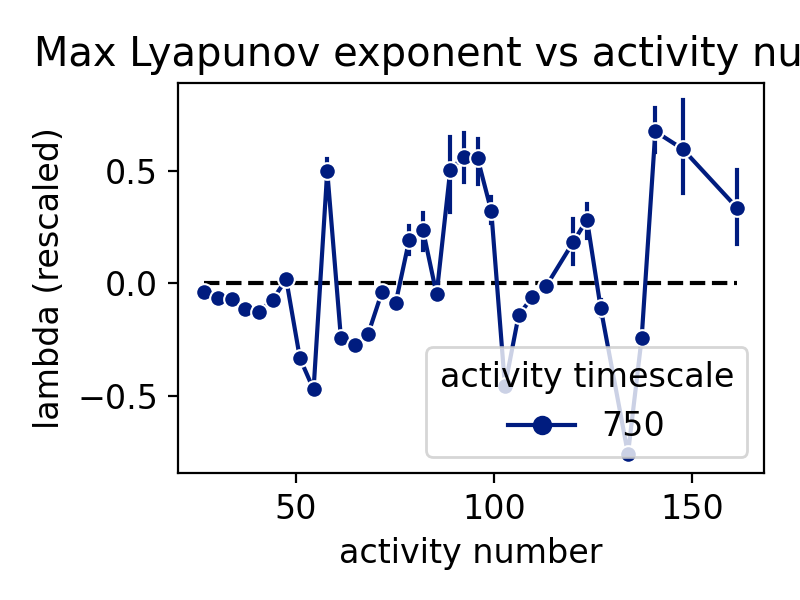

In [28]:
parameter = 'activity number'
title = 'Max Lyapunov exponent vs {}'.format(parameter)
plt.figure(figsize=(4,3))
sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (rescaled)', style = 'activity timescale', 
             hue="activity timescale", err_style = 'bars', markers = True, color = 'r', palette = 'dark')
plt.hlines(y=0, xmin=min(df_lyapunov[parameter]),xmax=max(df_lyapunov[parameter]), linestyle = '--', color = 'k')
plt.title(title)

plt.tight_layout()

plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)
plt.show()

In [26]:
os.getcwd()

'/home/deepak/PyFilaments/processing'